# 01


In [1]:
import os, sys 
import itertools
import collections
import random
import time 
import logging

from PIL import Image
from skimage import img_as_ubyte
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pyplot import imread

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import MultiStepLR

#########################################################################################################
torch.set_float32_matmul_precision('high')
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
ROOT_PROJECT = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/ImageRestoration-Development-Unrolling/"
ROOT_DATASET = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/"
# ROOT_PROJECT = "/home/dotamthuc/Works/Projects/ImageRestoration-Development-Unrolling/"
# ROOT_DATASET = "/home/dotamthuc/Works/Projects/ImageRestoration-Development-Unrolling"
#########################################################################################################

sys.path.append(os.path.join(ROOT_PROJECT, 'exploration/model_multiscale_mixture_GLR/lib'))
from dataloader import ImageSuperResolution


In [2]:
import itertools
import collections
import numpy as np
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch.profiler import profile, record_function, ProfilerActivity
# torch.set_default_dtype(torch.float64)

from einops import rearrange


class CustomLayerNorm(nn.Module):
    def __init__(self, nchannels):
        super(CustomLayerNorm, self).__init__()
        
        self.nchannels = nchannels
        self.weighted_transform = nn.Conv2d(nchannels, nchannels, kernel_size=1, stride=1, groups=nchannels, bias=False)

    def forward(self, x):
        # bz, nchannels, h, w = x.shape
        sigma = x.var(dim=1, keepdim=True, correction=1)
        # bz, 1, h, w = sigma.shape
        return self.weighted_transform(x / torch.sqrt(sigma+1e-5))
    


##########################################################################
class FeedForward(nn.Module):
    def __init__(self, dim, ffn_expansion_factor, bias):
        super(FeedForward, self).__init__()

        hidden_features = int(dim*ffn_expansion_factor)
        # hidden_features = dim

        self.project_in = nn.Conv2d(dim, hidden_features*2, kernel_size=1, bias=bias)

        self.dwconv = nn.Conv2d(hidden_features*2, hidden_features*2, kernel_size=3, stride=1, padding=1, groups=hidden_features*2, bias=bias)

        self.project_out = nn.Conv2d(hidden_features, dim, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.project_in(x)
        x1, x2 = self.dwconv(x).chunk(2, dim=1)
        x = nn.functional.gelu(x1) * x2
        x = self.project_out(x)
        return x


##########################################################################
class FFBlock(nn.Module):
    def __init__(self, dim, ffn_expansion_factor, bias):
        super(FFBlock, self).__init__()

        self.norm = CustomLayerNorm(dim)

        self.skip_connect_weight_final = Parameter(
            torch.ones((2), dtype=torch.float32) * torch.tensor([0.5, 0.5]),
            requires_grad=True
        )
        self.ffn = FeedForward(dim, ffn_expansion_factor, bias)

    def forward(self, x):
        x = self.skip_connect_weight_final[0]*x + self.skip_connect_weight_final[1]*self.ffn(self.norm(x))

        return x



##########################################################################
## Overlapped image patch embedding with 3x3 Conv
class OverlapPatchEmbed(nn.Module):
    def __init__(self, in_c=3, embed_dim=48, bias=False):
        super(OverlapPatchEmbed, self).__init__()

        self.proj = nn.Conv2d(in_c, embed_dim, kernel_size=3, stride=1, padding=1, bias=bias)

    def forward(self, x):
        x = self.proj(x)

        return x



##########################################################################
## Resizing modules
class Downsample(nn.Module):
    def __init__(self, n_feat):
        super(Downsample, self).__init__()

        self.body = nn.Sequential(nn.Conv2d(n_feat, n_feat//2, kernel_size=3, stride=1, padding=1, bias=False),
                                  nn.PixelUnshuffle(2))

        # self.body = nn.Sequential(nn.Conv2d(n_feat, n_feat//4, kernel_size=3, stride=1, padding=1, bias=False),
        #                           nn.PixelUnshuffle(2))
        
        # self.body = nn.Sequential(nn.Conv2d(n_feat, n_feat, kernel_size=3, stride=2, padding=1, padding_mode="replicate", bias=False))

    def forward(self, x):
        return self.body(x)

class Upsample(nn.Module):
    def __init__(self, n_feat):
        super(Upsample, self).__init__()

        self.body = nn.Sequential(nn.Conv2d(n_feat, n_feat*2, kernel_size=3, stride=1, padding=1, bias=False),
                                  nn.PixelShuffle(2))
        # self.body = nn.Sequential(nn.Conv2d(n_feat, n_feat*4, kernel_size=3, stride=1, padding=1, bias=False),
        #                           nn.PixelShuffle(2))

        # self.body = nn.Sequential(nn.ConvTranspose2d(n_feat, n_feat, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False))


    def forward(self, x):
        return self.body(x)

##########################################################################
# class FeatureExtraction(nn.Module):
#     def __init__(self, 
#         inp_channels=3, 
#         out_channels=48, 
#         dim = 48,
#         num_blocks = [2,2,2,2], 
#         num_refinement_blocks = 4,
#         ffn_expansion_factor = 2.0,
#         bias = False,
#     ):

#         super(FeatureExtraction, self).__init__()

#         self.patch_embed = OverlapPatchEmbed(inp_channels, dim)

#         self.encoder_level1 = nn.Sequential(*[FFBlock(dim=dim, ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in range(num_blocks[0])])
        
#         self.down1_2 = Downsample(dim) ## From Level 1 to Level 2
#         self.encoder_level2 = nn.Sequential(*[FFBlock(dim=int(dim), ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in range(num_blocks[1])])
        
#         self.down2_3 = Downsample(int(dim)) ## From Level 2 to Level 3
#         self.encoder_level3 = nn.Sequential(*[FFBlock(dim=int(dim), ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in range(num_blocks[2])])

#         self.down3_4 = Downsample(int(dim)) ## From Level 3 to Level 4
#         self.latent = nn.Sequential(*[FFBlock(dim=int(dim), ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in range(num_blocks[3])])
        
#         self.up4_3 = Upsample(int(dim)) ## From Level 4 to Level 3
#         self.reduce_chan_level3 = nn.Conv2d(int(dim*2), int(dim), kernel_size=1, bias=bias)
#         self.decoder_level3 = nn.Sequential(*[FFBlock(dim=int(dim), ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in range(num_blocks[2])])

#         self.up3_2 = Upsample(int(dim)) ## From Level 3 to Level 2
#         self.reduce_chan_level2 = nn.Conv2d(int(dim*2), int(dim), kernel_size=1, bias=bias)
#         self.decoder_level2 = nn.Sequential(*[FFBlock(dim=int(dim), ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in range(num_blocks[1])])
        
#         self.up2_1 = Upsample(int(dim))  ## From Level 2 to Level 1  (NO 1x1 conv to reduce channels)

#         self.decoder_level1 = nn.Sequential(*[FFBlock(dim=int(dim*2), ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in range(num_blocks[0])])
        
#         self.refinement = nn.Sequential(*[FFBlock(dim=int(dim*2), ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in range(num_refinement_blocks)])

#         ###########################
#         self.output = nn.Conv2d(int(dim*2), out_channels, kernel_size=3, stride=1, padding=1, bias=bias)

#     def forward(self, inp_img):

#         inp_enc_level1 = self.patch_embed(inp_img)
#         out_enc_level1 = self.encoder_level1(inp_enc_level1)
        
#         inp_enc_level2 = self.down1_2(out_enc_level1)
#         out_enc_level2 = self.encoder_level2(inp_enc_level2)

#         inp_enc_level3 = self.down2_3(out_enc_level2)
#         out_enc_level3 = self.encoder_level3(inp_enc_level3) 

#         inp_enc_level4 = self.down3_4(out_enc_level3)        
#         latent = self.latent(inp_enc_level4) 
                        
#         inp_dec_level3 = self.up4_3(latent)
#         inp_dec_level3 = torch.cat([inp_dec_level3, out_enc_level3], 1)
#         inp_dec_level3 = self.reduce_chan_level3(inp_dec_level3)
#         out_dec_level3 = self.decoder_level3(inp_dec_level3) 

#         inp_dec_level2 = self.up3_2(out_dec_level3)
#         inp_dec_level2 = torch.cat([inp_dec_level2, out_enc_level2], 1)
#         inp_dec_level2 = self.reduce_chan_level2(inp_dec_level2)
#         out_dec_level2 = self.decoder_level2(inp_dec_level2) 

#         inp_dec_level1 = self.up2_1(out_dec_level2)
#         inp_dec_level1 = torch.cat([inp_dec_level1, out_enc_level1], 1)
#         out_dec_level1 = self.decoder_level1(inp_dec_level1)
        
#         out_dec_level1 = self.refinement(out_dec_level1)
#         out_dec_level1 = self.output(out_dec_level1)

#         # return [latent, out_dec_level3, out_dec_level2, out_dec_level1]
#         return [out_dec_level1]

class FeatureExtraction(nn.Module):
    def __init__(self, 
        inp_channels=3, 
        out_channels=48, 
        dim = 48,
        num_blocks = [1,2,2,4], 
        num_refinement_blocks = 4,
        ffn_expansion_factor = 2.66,
        bias = False,
    ):

        super(FeatureExtraction, self).__init__()

        self.patch_embed = OverlapPatchEmbed(inp_channels, dim)

        self.encoder_level1 = nn.Sequential(*[FFBlock(dim=dim, ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in range(num_blocks[0])])
        
        self.down1_2 = Downsample(dim) ## From Level 1 to Level 2
        self.encoder_level2 = nn.Sequential(*[FFBlock(dim=int(dim*2**1), ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in range(num_blocks[1])])
        
        # self.down2_3 = Downsample(int(dim*2**1)) ## From Level 2 to Level 3
        # self.encoder_level3 = nn.Sequential(*[FFBlock(dim=int(dim*2**2), ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in range(num_blocks[2])])

        # self.down3_4 = Downsample(int(dim*2**2)) ## From Level 3 to Level 4
        # self.latent = nn.Sequential(*[FFBlock(dim=int(dim*2**3), ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in range(num_blocks[3])])
        
        # self.up4_3 = Upsample(int(dim*2**3)) ## From Level 4 to Level 3
        # self.reduce_chan_level3 = nn.Conv2d(int(dim*2**3), int(dim*2**2), kernel_size=1, bias=bias)
        # self.decoder_level3 = nn.Sequential(*[FFBlock(dim=int(dim*2**2), ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in range(num_blocks[2])])

        # self.up3_2 = Upsample(int(dim*2**2)) ## From Level 3 to Level 2
        # self.reduce_chan_level2 = nn.Conv2d(int(dim*2**2), int(dim*2**1), kernel_size=1, bias=bias)
        # self.decoder_level2 = nn.Sequential(*[FFBlock(dim=int(dim*2**1), ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in range(num_blocks[1])])
        
        self.up2_1 = Upsample(int(dim*2**1))  ## From Level 2 to Level 1  (NO 1x1 conv to reduce channels)

        self.decoder_level1 = nn.Sequential(*[FFBlock(dim=int(dim*2**1), ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in range(num_blocks[0])])
        
        self.refinement = nn.Sequential(*[FFBlock(dim=int(dim*2**1), ffn_expansion_factor=ffn_expansion_factor, bias=bias) for i in range(num_refinement_blocks)])

        ###########################
        self.output = nn.Conv2d(int(dim*2**1), out_channels, kernel_size=3, stride=1, padding=1, bias=bias)

    def forward(self, inp_img):

        inp_enc_level1 = self.patch_embed(inp_img)
        out_enc_level1 = self.encoder_level1(inp_enc_level1)
        
        inp_enc_level2 = self.down1_2(out_enc_level1)
        latent = self.encoder_level2(inp_enc_level2)

        # inp_enc_level3 = self.down2_3(out_enc_level2)
        # out_enc_level3 = self.encoder_level3(inp_enc_level3) 

        # inp_enc_level4 = self.down3_4(out_enc_level3)        
        # latent = self.latent(inp_enc_level4) 
                        
        # inp_dec_level3 = self.up4_3(latent)
        # inp_dec_level3 = torch.cat([inp_dec_level3, out_enc_level3], 1)
        # inp_dec_level3 = self.reduce_chan_level3(inp_dec_level3)
        # out_dec_level3 = self.decoder_level3(inp_dec_level3) 

        # inp_dec_level2 = self.up3_2(out_dec_level3)
        # inp_dec_level2 = torch.cat([inp_dec_level2, out_enc_level2], 1)
        # inp_dec_level2 = self.reduce_chan_level2(inp_dec_level2)
        # out_dec_level2 = self.decoder_level2(inp_dec_level2) 

        inp_dec_level1 = self.up2_1(latent)
        inp_dec_level1 = torch.cat([inp_dec_level1, out_enc_level1], 1)
        out_dec_level1 = self.decoder_level1(inp_dec_level1)
        
        out_dec_level1 = self.refinement(out_dec_level1)
        out_dec_level1 = self.output(out_dec_level1)

        return [out_dec_level1]
    



class GLRFast(nn.Module):
    def __init__(self, 
            n_channels, n_node_fts, n_graphs, connection_window, device, M_diag_init=0.4
        ):
        super(GLRFast, self).__init__()

        self.device = device
        self.n_channels        = n_channels
        self.n_node_fts        = n_node_fts
        self.n_graphs          = n_graphs
        self.n_edges           = (connection_window == 1).sum()
        self.connection_window = connection_window
        self.buffer_size       = connection_window.sum()

        # edges type from connection_window
        window_size = connection_window.shape[0]
        connection_window = connection_window.reshape((-1))
        m = np.arange(window_size)-window_size//2
        edge_delta = np.array(
            list(itertools.product(m, m)),
            dtype=np.int32
        )
        self.edge_delta = edge_delta[connection_window == 1]
        
        self.pad_dim_hw = np.abs(self.edge_delta.min(axis=0))


        kernel01 = torch.tensor([
            [0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0],
        ])
        kernel = []
        for r in range(self.n_channels):
            kernel.append(kernel01[np.newaxis, np.newaxis, :, :])

        kernel = torch.concat(kernel, axis=0).to(self.device)
        self.stats_kernel_p01 = Parameter(
            torch.ones((1), device=self.device, dtype=torch.float32) * 1.0,
            requires_grad=True,
        )
        self.stats_kernel01 = torch.ones((self.n_channels, 1, 3, 3), device=self.device, dtype=torch.float32) * kernel

        kernel02a = torch.tensor([
            [0.0, 0.0, 0.0],
            [0.0,-1.0, 1.0],
            [0.0, 0.0, 0.0],
        ])
        kernel = []
        for r in range(self.n_channels):
            kernel.append(kernel02a[np.newaxis, np.newaxis, :, :])

        kernel = torch.concat(kernel, axis=0).to(self.device)
        self.stats_kernel_p02a = Parameter(
            torch.ones((1), device=self.device, dtype=torch.float32) * 0.5,
            requires_grad=True,
        )
        self.stats_kernel02a = torch.ones((self.n_channels, 1, 3, 3), device=self.device, dtype=torch.float32) * kernel

        kernel02b = torch.tensor([
            [0.0, 0.0, 0.0],
            [0.0,-1.0, 0.0],
            [0.0, 1.0, 0.0],
        ])
        kernel = []
        for r in range(self.n_channels):
            kernel.append(kernel02b[np.newaxis, np.newaxis, :, :])

        kernel = torch.concat(kernel, axis=0).to(self.device)
        self.stats_kernel_p02b = Parameter(
            torch.ones((1), device=self.device, dtype=torch.float32) * 0.5,
            requires_grad=True,
        )
        self.stats_kernel02b = torch.ones((self.n_channels, 1, 3, 3), device=self.device, dtype=torch.float32) * kernel

        kernel03 = torch.tensor([
            [0.0, -1.0, 0.0],
            [-1.0, 4.0, -1.0],
            [0.0, -1.0, 0.0],
        ])
        kernel = []
        for r in range(self.n_channels):
            kernel.append(kernel03[np.newaxis, np.newaxis, :, :])

        kernel = torch.concat(kernel, axis=0).to(self.device)
        self.stats_kernel_p03 = Parameter(
            torch.ones((1), device=self.device, dtype=torch.float32) * 0.5,
            requires_grad=True,
        )
        self.stats_kernel03 = torch.ones((self.n_channels, 1, 3, 3), device=self.device, dtype=torch.float32) * kernel

        ### Trainable parameters
        # features on nodes #self.n_node_fts
        self.multiM = Parameter(
            torch.ones((self.n_graphs, self.n_node_fts), device=self.device, dtype=torch.float32)*M_diag_init,
            requires_grad=True,
        )



    def get_neighbors_pixels(self, img_features):
        _, _, H, W = img_features.shape
        padH, padW = self.pad_dim_hw
        img_features_frame = nn.functional.pad(img_features, (padW, padW, padH, padH), "replicate")
        # neighbors_pixels = []
        # for shift_h, shift_w in self.edge_delta:
        #     fromh = padH + shift_h
        #     toh = padH + shift_h + H
        #     fromw = padW + shift_w
        #     tow = padW + shift_w + W
            
        #     neighbors_pixels.append(
        #         img_features_frame[:, :, fromh:toh, fromw:tow]
        #     )
        # neighbors_pixels_features = torch.stack(neighbors_pixels, axis=-3)

        neighbors_pixels_features = torch.stack([
            img_features_frame[:, :, padH + self.edge_delta[0, 0]:padH + self.edge_delta[0, 0] + H, padW + self.edge_delta[0, 1]:padW + self.edge_delta[0, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[1, 0]:padH + self.edge_delta[1, 0] + H, padW + self.edge_delta[1, 1]:padW + self.edge_delta[1, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[2, 0]:padH + self.edge_delta[2, 0] + H, padW + self.edge_delta[2, 1]:padW + self.edge_delta[2, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[3, 0]:padH + self.edge_delta[3, 0] + H, padW + self.edge_delta[3, 1]:padW + self.edge_delta[3, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[4, 0]:padH + self.edge_delta[4, 0] + H, padW + self.edge_delta[4, 1]:padW + self.edge_delta[4, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[5, 0]:padH + self.edge_delta[5, 0] + H, padW + self.edge_delta[5, 1]:padW + self.edge_delta[5, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[6, 0]:padH + self.edge_delta[6, 0] + H, padW + self.edge_delta[6, 1]:padW + self.edge_delta[6, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[7, 0]:padH + self.edge_delta[7, 0] + H, padW + self.edge_delta[7, 1]:padW + self.edge_delta[7, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[8, 0]:padH + self.edge_delta[8, 0] + H, padW + self.edge_delta[8, 1]:padW + self.edge_delta[8, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[9, 0]:padH + self.edge_delta[9, 0] + H, padW + self.edge_delta[9, 1]:padW + self.edge_delta[9, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[10, 0]:padH + self.edge_delta[10, 0] + H, padW + self.edge_delta[10, 1]:padW + self.edge_delta[10, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[11, 0]:padH + self.edge_delta[11, 0] + H, padW + self.edge_delta[11, 1]:padW + self.edge_delta[11, 1] + W]
            # img_features_frame[:, :, padH + self.edge_delta[12, 0]:padH + self.edge_delta[12, 0] + H, padW + self.edge_delta[12, 1]:padW + self.edge_delta[12, 1] + W],
            # img_features_frame[:, :, padH + self.edge_delta[13, 0]:padH + self.edge_delta[13, 0] + H, padW + self.edge_delta[13, 1]:padW + self.edge_delta[13, 1] + W],
            # img_features_frame[:, :, padH + self.edge_delta[14, 0]:padH + self.edge_delta[14, 0] + H, padW + self.edge_delta[14, 1]:padW + self.edge_delta[14, 1] + W],
            # img_features_frame[:, :, padH + self.edge_delta[15, 0]:padH + self.edge_delta[15, 0] + H, padW + self.edge_delta[15, 1]:padW + self.edge_delta[15, 1] + W],
            # img_features_frame[:, :, padH + self.edge_delta[16, 0]:padH + self.edge_delta[16, 0] + H, padW + self.edge_delta[16, 1]:padW + self.edge_delta[16, 1] + W],
            # img_features_frame[:, :, padH + self.edge_delta[17, 0]:padH + self.edge_delta[17, 0] + H, padW + self.edge_delta[17, 1]:padW + self.edge_delta[17, 1] + W],
            # img_features_frame[:, :, padH + self.edge_delta[18, 0]:padH + self.edge_delta[18, 0] + H, padW + self.edge_delta[18, 1]:padW + self.edge_delta[18, 1] + W],
            # img_features_frame[:, :, padH + self.edge_delta[19, 0]:padH + self.edge_delta[19, 0] + H, padW + self.edge_delta[19, 1]:padW + self.edge_delta[19, 1] + W],
            # img_features_frame[:, :, padH + self.edge_delta[20, 0]:padH + self.edge_delta[20, 0] + H, padW + self.edge_delta[20, 1]:padW + self.edge_delta[20, 1] + W],
            # img_features_frame[:, :, padH + self.edge_delta[21, 0]:padH + self.edge_delta[21, 0] + H, padW + self.edge_delta[21, 1]:padW + self.edge_delta[21, 1] + W],
            # img_features_frame[:, :, padH + self.edge_delta[22, 0]:padH + self.edge_delta[22, 0] + H, padW + self.edge_delta[22, 1]:padW + self.edge_delta[22, 1] + W],
            # img_features_frame[:, :, padH + self.edge_delta[23, 0]:padH + self.edge_delta[23, 0] + H, padW + self.edge_delta[23, 1]:padW + self.edge_delta[23, 1] + W]
        ], axis=-3)
        return neighbors_pixels_features

    def normalize_and_transform_features(self, img_features):
        batch_size, n_graphs, n_node_fts, h_size, w_size = img_features.shape
        # img_features = img_features.view(batch_size, self.n_graphs, self.n_node_fts, h_size, w_size)
        img_features = torch.nn.functional.normalize(img_features, dim=2)

        img_features_transform = torch.einsum(
            "bhcHW, hc -> bhcHW", img_features, self.multiM
        )
    
        img_features_transform = img_features_transform.view(batch_size, self.n_graphs*self.n_node_fts, h_size, w_size)

        return img_features_transform


    def extract_edge_weights(self, img_features):
        
        batch_size, n_graphs, n_node_fts, h_size, w_size = img_features.shape

        img_features = self.normalize_and_transform_features(img_features)
        img_features_neighbors = self.get_neighbors_pixels(img_features)

        features_similarity = (img_features[:, :, None, :, :] * img_features_neighbors)
        features_similarity = features_similarity.view(
            batch_size, self.n_graphs, self.n_node_fts, self.n_edges, h_size, w_size
        ).sum(axis=2)

        edge_weights_norm = nn.functional.softmax(features_similarity, dim=2) 
        node_degree = edge_weights_norm.sum(axis=2)

        return edge_weights_norm, node_degree
    
    def stats_conv(self, patchs):
        stats_kernel = (
            self.stats_kernel_p01 * self.stats_kernel01
            + self.stats_kernel_p02a * self.stats_kernel02a
            + self.stats_kernel_p02b * self.stats_kernel02b
            + self.stats_kernel_p03 * self.stats_kernel03
        )
        batch_size, n_graphs, c_size, h_size, w_size = patchs.shape
        temp_patch = patchs.view(batch_size*n_graphs, c_size, h_size, w_size)
        temp_patch = nn.functional.pad(temp_patch, (1,1,1,1), 'reflect')
        temp_out_patch = nn.functional.conv2d(
            temp_patch,
            weight=stats_kernel,
            stride=1,
            padding=0,
            groups=self.n_channels,
        )
        out_patch = temp_out_patch.view(batch_size, n_graphs, c_size, h_size, w_size)
        return out_patch

    def stats_conv_transpose(self, patchs):

        stats_kernel = (
            self.stats_kernel_p01 * self.stats_kernel01
            + self.stats_kernel_p02a * self.stats_kernel02a
            + self.stats_kernel_p02b * self.stats_kernel02b
            + self.stats_kernel_p03 * self.stats_kernel03
        )
        batch_size, n_graphs, c_size, h_size, w_size = patchs.shape
        temp_patch = patchs.reshape(batch_size*n_graphs, c_size, h_size, w_size)
        temp_out_patch = nn.functional.conv_transpose2d(
            temp_patch,
            weight=stats_kernel,
            stride=1,
            padding=1,
            groups=self.n_channels,
        )
        out_patch = temp_out_patch.view(batch_size, n_graphs, c_size, h_size, w_size)
        return out_patch


    def op_L_norm(self, img_signals, edge_weights, node_degree):

        batch_size, n_graphs, n_channels, h_size, w_size = img_signals.shape
        img_features_neighbors = self.get_neighbors_pixels(
            img_signals.view(batch_size, n_graphs*n_channels, h_size, w_size)
        ).view(batch_size, n_graphs, n_channels, self.n_edges, h_size, w_size)
        Wx = torch.einsum(
            "bhceHW, bheHW -> bhcHW", img_features_neighbors, edge_weights
        )
        output = img_signals - Wx
        return output


    def forward(self, patchs, edge_weights, node_degree):
        # output_patchs = self.op_L_norm(patchs, edge_weights, node_degree)
        patchs = self.stats_conv(patchs)
        output_patchs = self.op_L_norm(patchs, edge_weights, node_degree)
        output_patchs = self.stats_conv_transpose(output_patchs)

        return output_patchs
    



class GTVFast(nn.Module):
    def __init__(self, 
            n_channels, n_node_fts, n_graphs, connection_window, device, M_diag_init=0.4
        ):
        super(GTVFast, self).__init__()

        self.device = device
        self.n_channels        = n_channels
        self.n_node_fts        = n_node_fts
        self.n_graphs          = n_graphs
        self.n_edges           = (connection_window == 1).sum()
        self.connection_window = connection_window
        self.buffer_size       = connection_window.sum()

        # edges type from connection_window
        window_size = connection_window.shape[0]
        connection_window = connection_window.reshape((-1))
        m = np.arange(window_size)-window_size//2
        edge_delta = np.array(
            list(itertools.product(m, m)),
            dtype=np.int32
        )
        self.edge_delta = edge_delta[connection_window == 1]
        
        self.pad_dim_hw = np.abs(self.edge_delta.min(axis=0))

        kernel01 = torch.tensor([
            [0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0],
        ])
        kernel = []
        for r in range(self.n_channels):
            kernel.append(kernel01[np.newaxis, np.newaxis, :, :])

        kernel = torch.concat(kernel, axis=0).to(self.device)
        self.stats_kernel_p01 = Parameter(
            torch.ones((1), device=self.device, dtype=torch.float32) * 1.0,
            requires_grad=True,
        )
        self.stats_kernel01 = torch.ones((self.n_channels, 1, 3, 3), device=self.device, dtype=torch.float32) * kernel

        kernel02a = torch.tensor([
            [0.0, 0.0, 0.0],
            [0.0,-1.0, 1.0],
            [0.0, 0.0, 0.0],
        ])
        kernel = []
        for r in range(self.n_channels):
            kernel.append(kernel02a[np.newaxis, np.newaxis, :, :])

        kernel = torch.concat(kernel, axis=0).to(self.device)
        self.stats_kernel_p02a = Parameter(
            torch.ones((1), device=self.device, dtype=torch.float32) * 0.5,
            requires_grad=True,
        )
        self.stats_kernel02a = torch.ones((self.n_channels, 1, 3, 3), device=self.device, dtype=torch.float32) * kernel

        kernel02b = torch.tensor([
            [0.0, 0.0, 0.0],
            [0.0,-1.0, 0.0],
            [0.0, 1.0, 0.0],
        ])
        kernel = []
        for r in range(self.n_channels):
            kernel.append(kernel02b[np.newaxis, np.newaxis, :, :])

        kernel = torch.concat(kernel, axis=0).to(self.device)
        self.stats_kernel_p02b = Parameter(
            torch.ones((1), device=self.device, dtype=torch.float32) * 0.5,
            requires_grad=True,
        )
        self.stats_kernel02b = torch.ones((self.n_channels, 1, 3, 3), device=self.device, dtype=torch.float32) * kernel

        kernel03 = torch.tensor([
            [0.0, -1.0, 0.0],
            [-1.0, 4.0, -1.0],
            [0.0, -1.0, 0.0],
        ])
        kernel = []
        for r in range(self.n_channels):
            kernel.append(kernel03[np.newaxis, np.newaxis, :, :])

        kernel = torch.concat(kernel, axis=0).to(self.device)
        self.stats_kernel_p03 = Parameter(
            torch.ones((1), device=self.device, dtype=torch.float32) * 0.5,
            requires_grad=True,
        )
        self.stats_kernel03 = torch.ones((self.n_channels, 1, 3, 3), device=self.device, dtype=torch.float32) * kernel

        ### Trainable parameters
        # features on nodes #self.n_node_fts
        self.multiM = Parameter(
            torch.ones((self.n_graphs, self.n_node_fts), device=self.device, dtype=torch.float32)*M_diag_init,
            requires_grad=True,
        )


    def get_neighbors_pixels(self, img_features):
        _, _, H, W = img_features.shape
        padH, padW = self.pad_dim_hw
        img_features_frame = nn.functional.pad(img_features, (padW, padW, padH, padH), "replicate")
        # neighbors_pixels = []
        # for shift_h, shift_w in self.edge_delta:
        #     fromh = padH + shift_h
        #     toh = padH + shift_h + H
        #     fromw = padW + shift_w
        #     tow = padW + shift_w + W
            
        #     neighbors_pixels.append(
        #         img_features_frame[:, :, fromh:toh, fromw:tow]
        #     )
        # neighbors_pixels_features = torch.stack(neighbors_pixels, axis=-3)
        neighbors_pixels_features = torch.stack([
            img_features_frame[:, :, padH + self.edge_delta[0, 0]:padH + self.edge_delta[0, 0] + H, padW + self.edge_delta[0, 1]:padW + self.edge_delta[0, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[1, 0]:padH + self.edge_delta[1, 0] + H, padW + self.edge_delta[1, 1]:padW + self.edge_delta[1, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[2, 0]:padH + self.edge_delta[2, 0] + H, padW + self.edge_delta[2, 1]:padW + self.edge_delta[2, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[3, 0]:padH + self.edge_delta[3, 0] + H, padW + self.edge_delta[3, 1]:padW + self.edge_delta[3, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[4, 0]:padH + self.edge_delta[4, 0] + H, padW + self.edge_delta[4, 1]:padW + self.edge_delta[4, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[5, 0]:padH + self.edge_delta[5, 0] + H, padW + self.edge_delta[5, 1]:padW + self.edge_delta[5, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[6, 0]:padH + self.edge_delta[6, 0] + H, padW + self.edge_delta[6, 1]:padW + self.edge_delta[6, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[7, 0]:padH + self.edge_delta[7, 0] + H, padW + self.edge_delta[7, 1]:padW + self.edge_delta[7, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[8, 0]:padH + self.edge_delta[8, 0] + H, padW + self.edge_delta[8, 1]:padW + self.edge_delta[8, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[9, 0]:padH + self.edge_delta[9, 0] + H, padW + self.edge_delta[9, 1]:padW + self.edge_delta[9, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[10, 0]:padH + self.edge_delta[10, 0] + H, padW + self.edge_delta[10, 1]:padW + self.edge_delta[10, 1] + W],
            img_features_frame[:, :, padH + self.edge_delta[11, 0]:padH + self.edge_delta[11, 0] + H, padW + self.edge_delta[11, 1]:padW + self.edge_delta[11, 1] + W]
            # img_features_frame[:, :, padH + self.edge_delta[12, 0]:padH + self.edge_delta[12, 0] + H, padW + self.edge_delta[12, 1]:padW + self.edge_delta[12, 1] + W],
            # img_features_frame[:, :, padH + self.edge_delta[13, 0]:padH + self.edge_delta[13, 0] + H, padW + self.edge_delta[13, 1]:padW + self.edge_delta[13, 1] + W],
            # img_features_frame[:, :, padH + self.edge_delta[14, 0]:padH + self.edge_delta[14, 0] + H, padW + self.edge_delta[14, 1]:padW + self.edge_delta[14, 1] + W],
            # img_features_frame[:, :, padH + self.edge_delta[15, 0]:padH + self.edge_delta[15, 0] + H, padW + self.edge_delta[15, 1]:padW + self.edge_delta[15, 1] + W],
            # img_features_frame[:, :, padH + self.edge_delta[16, 0]:padH + self.edge_delta[16, 0] + H, padW + self.edge_delta[16, 1]:padW + self.edge_delta[16, 1] + W],
            # img_features_frame[:, :, padH + self.edge_delta[17, 0]:padH + self.edge_delta[17, 0] + H, padW + self.edge_delta[17, 1]:padW + self.edge_delta[17, 1] + W],
            # img_features_frame[:, :, padH + self.edge_delta[18, 0]:padH + self.edge_delta[18, 0] + H, padW + self.edge_delta[18, 1]:padW + self.edge_delta[18, 1] + W],
            # img_features_frame[:, :, padH + self.edge_delta[19, 0]:padH + self.edge_delta[19, 0] + H, padW + self.edge_delta[19, 1]:padW + self.edge_delta[19, 1] + W],
            # img_features_frame[:, :, padH + self.edge_delta[20, 0]:padH + self.edge_delta[20, 0] + H, padW + self.edge_delta[20, 1]:padW + self.edge_delta[20, 1] + W],
            # img_features_frame[:, :, padH + self.edge_delta[21, 0]:padH + self.edge_delta[21, 0] + H, padW + self.edge_delta[21, 1]:padW + self.edge_delta[21, 1] + W],
            # img_features_frame[:, :, padH + self.edge_delta[22, 0]:padH + self.edge_delta[22, 0] + H, padW + self.edge_delta[22, 1]:padW + self.edge_delta[22, 1] + W],
            # img_features_frame[:, :, padH + self.edge_delta[23, 0]:padH + self.edge_delta[23, 0] + H, padW + self.edge_delta[23, 1]:padW + self.edge_delta[23, 1] + W]
        ], axis=-3)
        return neighbors_pixels_features
    

    def normalize_and_transform_features(self, img_features):
        batch_size, n_graphs, n_node_fts, h_size, w_size = img_features.shape
        # img_features = img_features.view(batch_size, self.n_graphs, self.n_node_fts, h_size, w_size)
        img_features = torch.nn.functional.normalize(img_features, dim=2)

        img_features_transform = torch.einsum(
            "bhcHW, hc -> bhcHW", img_features, self.multiM
        )
    
        img_features_transform = img_features_transform.view(batch_size, self.n_graphs*self.n_node_fts, h_size, w_size)

        return img_features_transform


    def extract_edge_weights(self, img_features):
        
        batch_size, n_graphs, n_node_fts, h_size, w_size = img_features.shape

        img_features = self.normalize_and_transform_features(img_features)
        img_features_neighbors = self.get_neighbors_pixels(img_features)

        features_similarity = (img_features[:, :, None, :, :] * img_features_neighbors)
        features_similarity = features_similarity.view(
            batch_size, self.n_graphs, self.n_node_fts, self.n_edges, h_size, w_size
        ).sum(axis=2)

        edge_weights_norm = nn.functional.softmax(features_similarity, dim=2) 
        node_degree = edge_weights_norm.sum(axis=2)

        return edge_weights_norm, node_degree


    def stats_conv(self, patchs):
        stats_kernel = (
            self.stats_kernel_p01 * self.stats_kernel01
            + self.stats_kernel_p02a * self.stats_kernel02a
            + self.stats_kernel_p02b * self.stats_kernel02b
            + self.stats_kernel_p03 * self.stats_kernel03
        )
        batch_size, n_graphs, c_size, h_size, w_size = patchs.shape
        temp_patch = patchs.view(batch_size*n_graphs, c_size, h_size, w_size)
        temp_patch = nn.functional.pad(temp_patch, (1,1,1,1), 'reflect')
        temp_out_patch = nn.functional.conv2d(
            temp_patch,
            weight=stats_kernel,
            stride=1,
            padding=0,
            groups=self.n_channels,
        )
        out_patch = temp_out_patch.view(batch_size, n_graphs, c_size, h_size, w_size)
        return out_patch

    def stats_conv_transpose(self, patchs):

        stats_kernel = (
            self.stats_kernel_p01 * self.stats_kernel01
            + self.stats_kernel_p02a * self.stats_kernel02a
            + self.stats_kernel_p02b * self.stats_kernel02b
            + self.stats_kernel_p03 * self.stats_kernel03
        )
        
        batch_size, n_graphs, c_size, h_size, w_size = patchs.shape
        temp_patch = patchs.reshape(batch_size*n_graphs, c_size, h_size, w_size)
        temp_out_patch = nn.functional.conv_transpose2d(
            temp_patch,
            weight=stats_kernel,
            stride=1,
            padding=1,
            groups=self.n_channels,
        )
        out_patch = temp_out_patch.view(batch_size, n_graphs, c_size, h_size, w_size)
        return out_patch


    def op_C(self, img_signals, edge_weights, node_degree):


        batch_size, n_graphs, n_channels, h_size, w_size = img_signals.shape
        # img_signals = self.stats_conv(img_signals)

        img_signals = self.stats_conv(img_signals)

        img_features_neighbors = self.get_neighbors_pixels(
            img_signals.view(batch_size, n_graphs*n_channels, h_size, w_size)
        ).view(batch_size, n_graphs, n_channels, self.n_edges, h_size, w_size)
        Cx1 = img_signals[:, :, :, None, :, :] * edge_weights[:, :, None, :, :, :]
        Cx2 = img_features_neighbors * edge_weights[:, :, None, :, :, :]
        
        output = Cx1 - Cx2

        return output
    
    def op_C_transpose(self, edge_signals, edge_weights, node_degree):

        batch_size, n_graphs, n_channels, n_edges, H, W = edge_signals.shape
        edge_signals = edge_signals * edge_weights[:, :, None, :, :, :]

        output = edge_signals.sum(axis=3)

        padH, padW = self.pad_dim_hw
        output = nn.functional.pad(
            output.view(batch_size, n_graphs*n_channels, H, W),
            (padW, padW, padH, padH), "replicate"
        ).view(batch_size, n_graphs, n_channels, H + 2*padH, W + 2*padW)

        i=0
        for shift_h, shift_w in self.edge_delta:
            fromh = padH + shift_h
            toh = padH + shift_h + H
            fromw = padW + shift_w
            tow = padW + shift_w + W
            
            output[:, :, :, fromh:toh, fromw:tow] = output[:, :, :, fromh:toh, fromw:tow] - edge_signals[:, :, :, i, :, :]
            i+=1

        output = output[:, :, :, padH:-padH, padW:-padW]

        output = self.stats_conv_transpose(output)
        return output

    def forward(self, patchs, edge_weights, node_degree):
        # C^T C
        edges_signals = self.op_C(patchs, edge_weights, node_degree)
        output_patchs = self.op_C_transpose(edges_signals, edge_weights, node_degree)

        return output_patchs


#########################################################################
class DCestimator(nn.Module):
    def __init__(self, dim_in, dim_out, hidden_features):
        super(DCestimator, self).__init__()

        self.project_in = nn.Conv2d(dim_in, hidden_features*2, kernel_size=1, bias=False)
        self.dwconv = nn.Conv2d(hidden_features*2, hidden_features*2, kernel_size=3, stride=1, padding=1, groups=hidden_features*2, bias=False)
        self.project_out = nn.Conv2d(hidden_features, dim_out, kernel_size=1, bias=False)

    def forward(self, patchs):

        out = self.project_in(patchs)
        out01, out02 = self.dwconv(out).chunk(2, dim=1)
        out = nn.functional.gelu(out01) * out02
        out = self.project_out(out)
        return out
    

class MixtureGTV(nn.Module):
    def __init__(self, 
            nchannels_in,
            n_graphs,
            n_node_fts,
            n_cnn_fts,
            connection_window,
            n_cgd_iters,
            alpha_init,
            beta_init,
            muy_init, ro_init, gamma_init,
            device
        ):
        super(MixtureGTV, self).__init__()

        self.device       = device
        self.n_graphs     = n_graphs
        self.n_node_fts   = n_node_fts
        self.n_total_fts  = n_graphs * n_node_fts
        self.n_cnn_fts    = n_cnn_fts
        self.n_levels     = 4
        self.n_cgd_iters  = n_cgd_iters
        self.nchannels_in = nchannels_in
        self.connection_window = connection_window

        self.alphaCGD =  Parameter(
            torch.ones((self.n_cgd_iters, n_graphs), device=self.device, dtype=torch.float32) * alpha_init,
            requires_grad=True
        )

        self.betaCGD =  Parameter(
            torch.ones((self.n_cgd_iters, n_graphs), device=self.device, dtype=torch.float32) * beta_init,
            requires_grad=True
        )

        self.patchs_features_extraction = FeatureExtraction(
            inp_channels=3, 
            out_channels=self.n_total_fts + 12, 
            dim=self.n_cnn_fts,
            num_blocks = [2, 3, 3, 4], 
            num_refinement_blocks = 4,
            ffn_expansion_factor = 2.6666,
            bias = False,
        ).to(self.device)

        self.combination_weight = nn.Sequential(
            nn.Conv2d(
                in_channels=self.n_total_fts, 
                out_channels=self.n_graphs, 
                kernel_size=1,
                stride=1,
                padding=0,
                padding_mode="zeros",
                bias=False
            ),
            nn.Softmax(dim=1)
        ).to(self.device)

        self.dc_estimator = DCestimator(12, 3, 12*2).to(self.device)

        self.ro00 = Parameter(
            torch.ones((n_graphs), device=self.device, dtype=torch.float32) * ro_init[0],
            requires_grad=True,
        )
        self.gamma00 = Parameter(
            torch.ones((n_graphs), device=self.device, dtype=torch.float32) * torch.log(gamma_init[0]),
            requires_grad=True,
        )
        self.GTVmodule00 = GTVFast(
            n_channels=self.nchannels_in,
            n_node_fts=self.n_node_fts,
            n_graphs=self.n_graphs,
            connection_window=self.connection_window,
            device=self.device,
            M_diag_init=1.0
        )

        self.muys00 = Parameter(
            torch.ones((n_graphs), device=self.device, dtype=torch.float32) * muy_init[0],
            requires_grad=True,
        )
        self.GLRmodule00 = GLRFast(
            n_channels=self.nchannels_in,
            n_node_fts=self.n_node_fts,
            n_graphs=self.n_graphs,
            connection_window=self.connection_window,
            device=self.device,
            M_diag_init=1.0
        )

    def apply_lightweight_transformer(self, patchs, list_graph_weightGTV, list_graph_weightGLR):

        batch_size, n_graphs, c_size, h_size, w_size = patchs.shape 
        patchs = patchs.contiguous()
        graph_weights, graph_degree = list_graph_weightGLR[0]

        Lpatchs = self.GLRmodule00(patchs, graph_weights, graph_degree)
        Lpatchs = torch.einsum(
            "bHchw, H -> bHchw", Lpatchs, self.muys00
        )

        graph_weights, graph_degree = list_graph_weightGTV[0]
        CtCpatchs = self.GTVmodule00(patchs, graph_weights, graph_degree)
        CtCpatchs = torch.einsum(
            "bHchw, H -> bHchw", CtCpatchs, self.ro00
        )

        output = patchs + Lpatchs + CtCpatchs

        return output
    
    def soft_threshold(self, delta, gamma):
        # batch_size, n_graphs, n_channels, n_edges, H, W = delta.shape
        # n_graphs = gamma.shape

        gamma = gamma[None, :, None, None, None, None]
        # print(f"Gamma.shape={gamma.shape}")

        condA = (delta < -gamma) 
        outputA = torch.where(
            condA,
            delta+gamma,
            0.0
        )
        condB = (delta > gamma) 
        outputB = torch.where(
            condB,
            delta-gamma,
            0.0
        )
        output = outputA + outputB
        return output


    def forward(self, patchs):
        # with record_function("MultiScaleMixtureGLR:forward"): 
        # print("#"*80)
        # patchs = patchs.permute(dims=(0, 3, 1, 2))
        # patchs = patchs.contiguous()
        # patchs = self.images_domain_to_abtract_domain(patchs)
        # print(f"patchs.shape={patchs.shape}")
        batch_size, c_size, h_size, w_size = patchs.shape

        #####
        ## Graph low pass filter
        
        list_features_patchs = self.patchs_features_extraction(patchs)
        list_graph_weightGTV = [None] * self.n_levels
        list_graph_weightGLR = [None] * self.n_levels
        bz, nfts, h, w = list_features_patchs[0].shape

        list_graph_weightGTV[0] = self.GTVmodule00.extract_edge_weights(
            list_features_patchs[0][:, :-12, :, :].view((bz, self.GTVmodule00.n_graphs, self.GTVmodule00.n_node_fts, h, w))
        )
        list_graph_weightGLR[0] = self.GLRmodule00.extract_edge_weights(
            list_features_patchs[0][:, :-12, :, :].view((bz, self.GLRmodule00.n_graphs, self.GLRmodule00.n_node_fts, h, w))
        )


        dc_term = self.dc_estimator(list_features_patchs[0][:, -12:, :, :])
        y_tilde = patchs - dc_term
        ###########################################################


        epsilon = self.GTVmodule00.op_C(y_tilde[:, None, :, :, :], list_graph_weightGTV[0][0], list_graph_weightGTV[0][1])
        bias    = torch.zeros_like(epsilon)

        left_hand_size = self.GTVmodule00.op_C_transpose(epsilon - bias, list_graph_weightGTV[0][0], list_graph_weightGTV[0][1]) 
        left_hand_size *= self.ro00[None, :, None, None, None]
        left_hand_size += y_tilde[:, None, :, :, :]
        ############################################################
        output = left_hand_size
        system_residual = left_hand_size -  self.apply_lightweight_transformer(output, list_graph_weightGTV, list_graph_weightGLR)
        update = system_residual
        output = output + self.alphaCGD[0, None, :, None, None, None] * update

        system_residual = left_hand_size -  self.apply_lightweight_transformer(output, list_graph_weightGTV, list_graph_weightGLR)
        update = system_residual + self.betaCGD[1, None, :, None, None, None] * update
        output = output + self.alphaCGD[1, None, :, None, None, None] * update

        epsilon = self.soft_threshold(
            self.GTVmodule00.op_C(output, list_graph_weightGTV[0][0], list_graph_weightGTV[0][1]) + bias,
            torch.exp(self.gamma00)
        )
        bias  = bias + (self.GTVmodule00.op_C(output, list_graph_weightGTV[0][0], list_graph_weightGTV[0][1]) - epsilon)

        left_hand_size = self.GTVmodule00.op_C_transpose(epsilon - bias, list_graph_weightGTV[0][0], list_graph_weightGTV[0][1]) 
        left_hand_size *= self.ro00[None, :, None, None, None]
        left_hand_size += y_tilde[:, None, :, :, :]
        ############################################################

        output = left_hand_size
        system_residual = left_hand_size -  self.apply_lightweight_transformer(output, list_graph_weightGTV, list_graph_weightGLR)
        update = system_residual
        output = output + self.alphaCGD[2, None, :, None, None, None] * update

        system_residual = left_hand_size -  self.apply_lightweight_transformer(output, list_graph_weightGTV, list_graph_weightGLR)
        update = system_residual + self.betaCGD[3, None, :, None, None, None] * update
        output = output + self.alphaCGD[3, None, :, None, None, None] * update

        # system_residual = left_hand_size -  self.apply_lightweight_transformer(output, list_graph_weightGTV, list_graph_weightGLR)
        # update = system_residual + self.betaCGD[4, None, :, None, None, None] * update
        # output = output + self.alphaCGD[4, None, :, None, None, None] * update
        
        # system_residual = left_hand_size -  self.apply_lightweight_transformer(output, list_graph_weightGTV, list_graph_weightGLR)
        # update = system_residual + self.betaCGD[5, None, :, None, None, None] * update
        # output = output + self.alphaCGD[5, None, :, None, None, None] * update
        

        score = self.combination_weight(list_features_patchs[0][:, :-12, :, :])
        output = torch.einsum(
            "bgchw, bghw -> bchw", output, score
        ) + dc_term

        return output


#########################################################################
class SharpeningBlock(nn.Module):
    def __init__(self, dim_in, dim_out, hidden_features):
        super(SharpeningBlock, self).__init__()

        self.project_in = nn.Conv2d(dim_in, hidden_features*2, kernel_size=1, bias=False)
        self.dwconv = nn.Conv2d(hidden_features*2, hidden_features*2, kernel_size=3, stride=1, padding=1, groups=hidden_features*2, bias=False)
        self.project_out = nn.Conv2d(hidden_features, dim_out, kernel_size=1, bias=False)
        self.skip_connect_weight = Parameter(
            torch.ones((2), dtype=torch.float32) * torch.tensor([0.5, 0.5]),
            requires_grad=True
        )
        
    def forward(self, patchs):

        out = self.project_in(patchs)
        out01, out02 = self.dwconv(out).chunk(2, dim=1)
        out = nn.functional.gelu(out01) * out02
        out = self.project_out(out)
        out = self.skip_connect_weight[0] * patchs + self.skip_connect_weight[1] * out
        return out

class MultiScaleSequenceDenoiser(nn.Module):
    def __init__(self, device):
        super(MultiScaleSequenceDenoiser, self).__init__()
        self.device = device

        # CONNECTION_FLAGS_5x5 = np.array([
        #     1,1,1,1,1,
        #     1,1,1,1,1,
        #     1,1,0,1,1,
        #     1,1,1,1,1,
        #     1,1,1,1,1,
        # ]).reshape((5,5))
        CONNECTION_FLAGS_5x5_small = np.array([
            0,0,1,0,0,
            0,1,1,1,0,
            1,1,0,1,1,
            0,1,1,1,0,
            0,0,1,0,0,
        ]).reshape((5,5))
        self.skip_connect_weight02 = Parameter(
            torch.ones((2), dtype=torch.float32, device=self.device) * torch.tensor([0.1, 0.9]).to(device),
            requires_grad=True
        )
        self.mixtureGLR_block02 = MixtureGTV(
            nchannels_in=3,
            n_graphs=16,
            n_node_fts=3,
            n_cnn_fts=48,
            connection_window=CONNECTION_FLAGS_5x5_small,
            n_cgd_iters=4,
            alpha_init=0.5,
            beta_init=0.1,
            muy_init=torch.tensor([[0.1], [0.0], [0.0], [0.0]]).to(self.device),
            ro_init=torch.tensor([[0.1], [0.0], [0.0], [0.0]]).to(self.device),
            gamma_init=torch.tensor([[0.001], [0.0], [0.0], [0.0]]).to(self.device),
            device=self.device
        )

        self.skip_connect_weight03 = Parameter(
            torch.ones((2), dtype=torch.float32, device=self.device) * torch.tensor([0.5, 0.5]).to(device),
            requires_grad=True
        )
        self.mixtureGLR_block03 = MixtureGTV(
            nchannels_in=3,
            n_graphs=16,
            n_node_fts=3,
            n_cnn_fts=48,
            connection_window=CONNECTION_FLAGS_5x5_small,
            n_cgd_iters=4,
            alpha_init=0.5,
            beta_init=0.1,
            muy_init=torch.tensor([[0.1], [0.0], [0.0], [0.0]]).to(self.device),
            ro_init=torch.tensor([[0.1], [0.0], [0.0], [0.0]]).to(self.device),
            gamma_init=torch.tensor([[0.001], [0.0], [0.0], [0.0]]).to(self.device),
            device=self.device
        )
    
    def forward(self, patchs):
        
        output = self.skip_connect_weight02[0] * patchs + self.skip_connect_weight02[1] * self.mixtureGLR_block03(patchs)
        output = self.skip_connect_weight03[0] * output + self.skip_connect_weight03[1] * self.mixtureGLR_block03(output)
        return output



In [3]:


LOG_DIR = os.path.join(ROOT_PROJECT, "exploration/model_multiscale_mixture_GLR/scripts/")
LOGGER = logging.getLogger("main")
logging.basicConfig(
    format='%(asctime)s: %(message)s', 
    datefmt='%m/%d/%Y %I:%M:%S %p',
    filename=os.path.join(LOG_DIR, 'non.log'), 
    level=logging.INFO
)

VERBOSE_RATE = 1000

(H_train01, W_train01) = (64, 64)
(H_train02, W_train02) = (128, 128)
(H_train03, W_train03) = (256, 256)
(H_train04, W_train04) = (512, 512)

(H_val, W_val) = (128, 128)
(H_test, W_test) = (496, 496)

train_dataset01 = ImageSuperResolution(
    csv_path=os.path.join(ROOT_DATASET, "dataset/DFWB_training_data_info.csv"),
    dist_mode="vary_addictive_noise",
    lambda_noise=[[1.0, 10.0, 15.0, 20.0, 25.0], [0.1, 0.1, 0.1, 0.1, 0.6]],
    use_data_aug=True,
    patch_size=(H_train01,H_train01),
    patch_overlap_size=(H_train01//4,H_train01//4),
    max_num_patchs=3200000,
    root_folder=ROOT_DATASET,
    logger=LOGGER,
    device=torch.device("cpu"),
)
data_train_batched01 = torch.utils.data.DataLoader(
    train_dataset01, batch_size=16, num_workers=4
)

In [ ]:
NUM_EPOCHS = 1


model = MultiScaleSequenceDenoiser(device=DEVICE)

s = 0
for p in model.parameters():
    s += np.prod(np.array(p.shape))
print(f"Init model with total parameters: {s}")

criterian = nn.L1Loss()
optimizer = Adam(
    model.parameters(),
    lr=0.0004,
    eps=1e-08
)
lr_scheduler = MultiStepLR(
    optimizer,
    milestones=[200000, 500000, 650000], gamma=0.5
)

model.train()
i = 0
### TRAINING
list_train_mse = []
list_train_psnr = []
for patchs_noisy, patchs_true in data_train_batched01:
    s = time.time()
    optimizer.zero_grad()
    patchs_noisy = patchs_noisy.to(DEVICE)
    patchs_true = patchs_true.to(DEVICE) 
    reconstruct_patchs = model(patchs_noisy.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
    loss_value = criterian(reconstruct_patchs, patchs_true)
    loss_value.backward()
    optimizer.step()
    lr_scheduler.step()

    img_true = np.clip(patchs_true.detach().cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
    img_recon = np.clip(reconstruct_patchs.detach().cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
    train_mse_value = np.square(img_true- img_recon).mean()
    train_psnr = 10 * np.log10(1/train_mse_value)
    list_train_psnr.append(train_psnr)
    list_train_mse.append(train_mse_value)

    print(f"iter={i} time={time.time()-s} psnr={np.mean(list_train_psnr[-100:])} mse={np.mean(list_train_mse[-100:])}")
    i+=1

    if (i%1000 == 0):

        model.eval()
        csv_path = os.path.join(ROOT_DATASET, "dataset/McMaster_testing_data_info.csv")
        img_infos = pd.read_csv(csv_path, index_col='index')

        paths = img_infos["path"].tolist()
        paths = [
            os.path.join(ROOT_DATASET,path)
            for path in paths
        ]

        sigma_test = 25.0
        factor = 8
        list_test_mse = []
        random_state = np.random.RandomState(seed=2204)
        test_i = 0
        s = time.time()
        for file_ in paths:
            torch.cuda.ipc_collect()
            torch.cuda.empty_cache()

            img = Image.open(file_)
            img_true_255 = np.array(img).astype(np.float32)
            img_true = img_true_255 / 255.0

            noisy_img_raw = img_true.copy()
            noisy_img_raw += random_state.normal(0, sigma_test/255., img_true.shape)

            noisy_img = torch.from_numpy(noisy_img_raw).permute(2,0,1)
            noisy_img = noisy_img.unsqueeze(0)

            h,w = noisy_img.shape[2], noisy_img.shape[3]
            H,W = ((h+factor)//factor)*factor, ((w+factor)//factor)*factor
            padh = H-h if h%factor!=0 else 0
            padw = W-w if w%factor!=0 else 0
            noisy_img = nn.functional.pad(noisy_img, (0,padw,0,padh), 'reflect')

            with torch.no_grad():
                restored = model(noisy_img.to(DEVICE))

            restored = restored[:,:,:h,:w]
            restored = torch.clamp(restored,0,1).cpu().detach().permute(0, 2, 3, 1).squeeze(0).numpy().copy()

            restored = img_as_ubyte(restored).astype(np.float32)
            test_mse_value = np.square(img_true_255- restored).mean()
            list_test_mse.append(test_mse_value)
            # print(f"test_i={test_i} time={time.time()-s} test_i_psnr_value={20 * np.log10(255.0 / np.sqrt(test_mse_value))}")  
            test_i += 1
            s = time.time()

        psnr_testing = 20 * np.log10(255.0 / np.sqrt(list_test_mse))
        print(f"FINISH TESTING - iter={i} -  psnr_testing={np.mean(psnr_testing)}")
        model.train()


Init model with total parameters: 1951844
iter=0 time=1.0051274299621582 psnr=26.239173782617534 mse=0.0023772925082516183
iter=1 time=0.566617488861084 psnr=26.69866545149302 mse=0.002150600226300952
iter=2 time=0.5650675296783447 psnr=26.765420934834214 mse=0.00211448020051078
iter=3 time=0.5655529499053955 psnr=26.64339318672556 mse=0.0021749872688009418
iter=4 time=0.5646185874938965 psnr=26.50952083318059 mse=0.0022453800586613865
iter=5 time=0.5650131702423096 psnr=26.366323327174403 mse=0.0023248985149751113
iter=6 time=0.5675699710845947 psnr=26.239467201627587 mse=0.0023974102518003726
iter=7 time=0.5648601055145264 psnr=26.15526484740804 mse=0.0024447305357977183
iter=8 time=0.564903974533081 psnr=26.153788018718394 mse=0.0024432159309070783
iter=9 time=0.5648205280303955 psnr=26.15587111698976 mse=0.0024401836580156947
iter=10 time=0.5658564567565918 psnr=26.149005140768228 mse=0.002442516346370907
iter=11 time=0.5651144981384277 psnr=26.150208900725374 mse=0.002440565519149

In [ ]:
model.state_dict()

# 02


In [1]:
import os, sys 
import itertools
import collections
import random
import time 
import logging

from PIL import Image
from skimage import img_as_ubyte
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pyplot import imread

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import MultiStepLR

#########################################################################################################
torch.set_float32_matmul_precision('high')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ROOT_PROJECT = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/ImageRestoration-Development-Unrolling/"
ROOT_DATASET = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/"
# ROOT_PROJECT = "/home/dotamthuc/Works/Projects/ImageRestoration-Development-Unrolling/"
# ROOT_DATASET = "/home/dotamthuc/Works/Projects/ImageRestoration-Development-Unrolling"
#########################################################################################################

sys.path.append(os.path.join(ROOT_PROJECT, 'exploration/model_multiscale_mixture_GLR/lib'))
from dataloader import ImageSuperResolution


In [2]:
import itertools
import collections
import numpy as np
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch.profiler import profile, record_function, ProfilerActivity
# torch.set_default_dtype(torch.float64)

from einops import rearrange


##########################################################################
class CustomLayerNorm(nn.Module):
    def __init__(self, nchannels):
        super(CustomLayerNorm, self).__init__()
        
        self.nchannels = nchannels
        self.weighted_transform = nn.Conv2d(nchannels, nchannels, kernel_size=1, stride=1, groups=nchannels, bias=False)

    def forward(self, x):
        # bz, nchannels, h, w = x.shape
        sigma = x.var(dim=1, keepdim=True, correction=1)
        # bz, 1, h, w = sigma.shape
        return self.weighted_transform(x / torch.sqrt(sigma+1e-5))



##########################################################################
class LocalGatedLinearBlock(nn.Module):
    def __init__(self, dim, hidden_dim):
        super(LocalGatedLinearBlock, self).__init__()

        self.channels_linear_op       = nn.Conv2d(dim, hidden_dim*2, kernel_size=1, bias=False)
        self.channels_local_linear_op = nn.Conv2d(
            hidden_dim*2, hidden_dim*2, 
            kernel_size=3, stride=1, 
            padding=1, padding_mode="replicate",
            groups=hidden_dim*2, 
            bias=False
        )
        self.project_out = nn.Conv2d(hidden_dim, dim, kernel_size=1, bias=False)

    def forward(self, x):
        x = self.channels_linear_op(x)
        mask, x = self.channels_local_linear_op(x).chunk(2, dim=1)
        x = nn.functional.sigmoid(mask) * x
        x = self.project_out(x)
        return x


##########################################################################
class LocalLowpassFilteringBlock(nn.Module):
    def __init__(self, dim):
        super(LocalLowpassFilteringBlock, self).__init__()

        # Filter Layer
        # self.norm_filter = CustomLayerNorm(dim)
        # self.local_linear_filter = nn.Conv2d(
        #     dim, dim, 
        #     kernel_size=3, stride=1, 
        #     padding=1, padding_mode="replicate",
        #     groups=dim, 
        #     bias=False
        # )
        # self.skip_weight_filter = Parameter(
        #     torch.tensor([0.5, 0.5], dtype=torch.float32),
        #     requires_grad=True
        # )

        # Linear Layer
        self.norm = CustomLayerNorm(dim)
        self.local_linear = LocalGatedLinearBlock(dim, dim*2)
        self.skip_weight= Parameter(
            torch.tensor([0.5, 0.5], dtype=torch.float32),
            requires_grad=True
        )
    def forward(self, x):
        # x = self.skip_weight_filter[0] * x + self.skip_weight_filter[1] * self.local_linear_filter(self.norm_filter(x))
        x = self.skip_weight[0] * x + self.skip_weight[1] * self.local_linear(self.norm(x))
        return x


##########################################################################
class ReginalPixelEmbeding(nn.Module):
    def __init__(self, n_channels_in=3, dim=48, bias=False):
        super(ReginalPixelEmbeding, self).__init__()

        self.channels_local_linear_op01 = nn.Conv2d(
            n_channels_in, dim*2, 
            kernel_size=3, stride=1, 
            padding=1, padding_mode="replicate",
            bias=False
        )
        # self.project_out = nn.Conv2d(dim//2, dim, kernel_size=1, bias=False)

    def forward(self, x):

        mask, x = self.channels_local_linear_op01(x).chunk(2, dim=1)
        x = nn.functional.sigmoid(mask) * mask * x
        # x = self.channels_local_linear_op01(x)

        return x


# ##########################################################################
# ## Down/Up Sampling
# class Downsampling(nn.Module):
#     def __init__(self, dim_in, dim_out):
#         super(Downsampling, self).__init__()

#         self.local_linear = nn.Conv2d(dim_in, dim_out//4, kernel_size=3, stride=1, padding=1, padding_mode="replicate", bias=False)
#         self.local_concat = nn.PixelUnshuffle(2)

#     def forward(self, x):
#         x = self.local_concat(self.local_linear(x))
#         return x

# class Upsampling(nn.Module):
#     def __init__(self, dim_in, dim_out):
#         super(Upsampling, self).__init__()

#         self.local_linear = nn.Conv2d(dim_in, dim_out*4, kernel_size=3, stride=1, padding=1, padding_mode="replicate", bias=False)
#         self.local_concat = nn.PixelShuffle(2)

#     def forward(self, x):
#         x = self.local_concat(self.local_linear(x))
#         return x

##########################################################################
## Down/Up Sampling
class Downsampling(nn.Module):
    def __init__(self, dim_in, dim_out):
        super(Downsampling, self).__init__()

        self.local_linear = nn.Conv2d(dim_in, dim_out//2, kernel_size=3, stride=1, padding=1, padding_mode="replicate", bias=False)
        self.local_concat = nn.PixelUnshuffle(2)

    def forward(self, x):
        mask, x = self.local_linear(x).chunk(2, dim=1)
        x = nn.functional.sigmoid(mask) * mask * x
        x = self.local_concat(x)
        return x

class Upsampling(nn.Module):
    def __init__(self, dim_in, dim_out):
        super(Upsampling, self).__init__()

        self.local_linear = nn.Conv2d(dim_in, dim_out*8, kernel_size=3, stride=1, padding=1, padding_mode="replicate", bias=False)
        self.local_concat = nn.PixelShuffle(2)

    def forward(self, x):
        # print(f"Upsampling in:{x.shape}")
        mask, x = self.local_linear(x).chunk(2, dim=1)
        # print(f"Upsampling out//4:{x.shape}")
        x = nn.functional.sigmoid(mask) * mask * x
        x = self.local_concat(x)
        # print(f"Upsampling out:{x.shape}")
        return x


class AbtractMultiScaleGraphFilter(nn.Module):
    def __init__(self, 
        n_channels_in=3, 
        n_channels_out=3, 
        dims=[48, 64, 96, 128],
        num_blocks=[4, 6, 6, 8], 
        num_blocks_out=4
    ):

        super(AbtractMultiScaleGraphFilter, self).__init__()

        self.patch_3x3_embeding = ReginalPixelEmbeding(n_channels_in, dims[0])
        self.encoder_scale_00 = nn.Sequential(*[
            LocalLowpassFilteringBlock(dim=dims[0]) for i in range(num_blocks[0])
        ])
        
        self.down_sample_00_01 = Downsampling(dim_in=dims[0], dim_out=dims[1]) 
        self.encoder_scale_01 = nn.Sequential(*[
            LocalLowpassFilteringBlock(dim=dims[1]) for i in range(num_blocks[1])
        ])

        self.down_sample_01_02 = Downsampling(dim_in=dims[1], dim_out=dims[2]) 
        self.encoder_scale_02 = nn.Sequential(*[
            LocalLowpassFilteringBlock(dim=dims[2]) for i in range(num_blocks[2])
        ])

        self.down_sample_02_03 = Downsampling(dim_in=dims[2], dim_out=dims[3]) 
        self.encoder_scale_03 = nn.Sequential(*[
            LocalLowpassFilteringBlock(dim=dims[3]) for i in range(num_blocks[3])
        ])


        self.up_sample_03_02 = Upsampling(dim_in=dims[3], dim_out=dims[2])
        self.combine_channels_02 = nn.Conv2d(dims[2]*2, dims[2], kernel_size=1, bias=False)
        self.decoder_scale_02 = nn.Sequential(*[
            LocalLowpassFilteringBlock(dim=dims[2]) for i in range(num_blocks[2])
        ])

        self.up_sample_02_01 = Upsampling(dim_in=dims[2], dim_out=dims[1])
        self.combine_channels_01 = nn.Conv2d(dims[1]*2, dims[1], kernel_size=1, bias=False)
        self.decoder_scale_01 = nn.Sequential(*[
            LocalLowpassFilteringBlock(dim=dims[1]) for i in range(num_blocks[1])
        ])

        self.up_sample_01_00 = Upsampling(dim_in=dims[1], dim_out=dims[0])
        self.combine_channels_00 = nn.Conv2d(dims[0]*2, dims[0], kernel_size=1, bias=False)
        self.decoder_scale_00 = nn.Sequential(*[
            LocalLowpassFilteringBlock(dim=dims[0]) for i in range(num_blocks[0])
        ])

        self.refining_block = nn.Sequential(*[
            LocalLowpassFilteringBlock(dim=dims[0]) for i in range(num_blocks_out)
        ])
        self.linear_output = nn.Conv2d(dims[0], n_channels_out, kernel_size=1, bias=False)
        self.skip_weight_output = Parameter(
            torch.tensor([0.5, 0.5], dtype=torch.float32),
            requires_grad=True
        )
    def forward(self, img):
        
        # Downward
        inp_enc_scale_00 = self.patch_3x3_embeding(img)
        out_enc_scale_00 = self.encoder_scale_00(inp_enc_scale_00)
        # print(f"out_enc_scale_00:{out_enc_scale_00.shape}")
        
        inp_enc_scale_01 = self.down_sample_00_01(out_enc_scale_00)
        out_enc_scale_01 = self.encoder_scale_01(inp_enc_scale_01)
        # print(f"inp_enc_scale_01:{inp_enc_scale_01.shape}")

        inp_enc_scale_02 = self.down_sample_01_02(out_enc_scale_01)
        out_enc_scale_02 = self.encoder_scale_02(inp_enc_scale_02)
        # print(f"inp_enc_scale_02:{inp_enc_scale_02.shape}")

        inp_enc_scale_03 = self.down_sample_02_03(out_enc_scale_02)
        out_enc_scale_03 = self.encoder_scale_03(inp_enc_scale_03)
        # print(f"inp_enc_scale_03:{inp_enc_scale_03.shape}")

        # Upward
        inp_dec_scale_02 = self.up_sample_03_02(out_enc_scale_03)
        # print(f"inp_dec_scale_02={inp_dec_scale_02.shape}")
        out_dec_scale_02 = torch.cat([inp_dec_scale_02, out_enc_scale_02], 1)
        # print(f"out_dec_scale_02={out_dec_scale_02.shape}")
        out_dec_scale_02 = self.combine_channels_02(out_dec_scale_02)
        # print(f"out_dec_scale_02={out_dec_scale_02.shape}")
        out_dec_scale_02 = self.decoder_scale_02(out_dec_scale_02)
        # print(f"out_dec_scale_02={out_dec_scale_02.shape}")

        inp_dec_scale_01 = self.up_sample_02_01(out_dec_scale_02)
        # print(f"inp_dec_scale_01={inp_dec_scale_01.shape}")
        out_dec_scale_01 = torch.cat([inp_dec_scale_01, out_enc_scale_01], 1)
        # print(f"out_dec_scale_01={out_dec_scale_01.shape}")
        out_dec_scale_01 = self.combine_channels_01(out_dec_scale_01)
        # print(f"out_dec_scale_01={out_dec_scale_01.shape}")
        out_dec_scale_01 = self.decoder_scale_01(out_dec_scale_01)
        # print(f"out_dec_scale_01={out_dec_scale_01.shape}")

        inp_dec_scale_00 = self.up_sample_01_00(out_dec_scale_01)
        # print(f"inp_dec_scale_00={inp_dec_scale_00.shape}")
        out_dec_scale_00 = torch.cat([inp_dec_scale_00, out_enc_scale_00], 1)
        # print(f"out_dec_scale_00={out_dec_scale_00.shape}")
        out_dec_scale_00 = self.combine_channels_00(out_dec_scale_00)
        # print(f"out_dec_scale_00={out_dec_scale_00.shape}")
        out_dec_scale_00 = self.decoder_scale_00(out_dec_scale_00)
        # print(f"out_dec_scale_00={out_dec_scale_00.shape}")

        output = self.refining_block(out_dec_scale_00)
        # print(f"output={output.shape}")
        output = self.linear_output(output) 
        # print(f"output={output.shape}")
        output = self.skip_weight_output[0] * img + self.skip_weight_output[1] * output
        # print(f"output={output.shape}")

        return output

In [3]:


LOG_DIR = os.path.join(ROOT_PROJECT, "exploration/model_multiscale_mixture_GLR/scripts/")
LOGGER = logging.getLogger("main")
logging.basicConfig(
    format='%(asctime)s: %(message)s', 
    datefmt='%m/%d/%Y %I:%M:%S %p',
    filename=os.path.join(LOG_DIR, 'non.log'), 
    level=logging.INFO
)

VERBOSE_RATE = 1000

(H_train01, W_train01) = (64, 64)
(H_train02, W_train02) = (128, 128)
(H_train03, W_train03) = (256, 256)
(H_train04, W_train04) = (512, 512)

(H_val, W_val) = (128, 128)
(H_test, W_test) = (496, 496)

train_dataset01 = ImageSuperResolution(
    csv_path=os.path.join(ROOT_DATASET, "dataset/DFWB_training_data_info.csv"),
    dist_mode="vary_addictive_noise",
    lambda_noise=[[1.0, 10.0, 15.0, 20.0, 25.0], [0.1, 0.1, 0.1, 0.1, 0.6]],
    use_data_aug=True,
    patch_size=(H_train02,H_train02),
    patch_overlap_size=(H_train02//4,H_train02//4),
    max_num_patchs=3200000,
    root_folder=ROOT_DATASET,
    logger=LOGGER,
    device=torch.device("cpu"),
)
data_train_batched01 = torch.utils.data.DataLoader(
    train_dataset01, batch_size=4, num_workers=4
)

In [4]:
# model = AbtractMultiScaleGraphFilter(
#     n_channels_in=3, 
#     n_channels_out=3, 
#     dims=[48, 64, 96, 128],
#     num_blocks=[4, 6, 6, 8], 
#     num_blocks_out=4
# ).to(DEVICE)
# model.compile()
# s = 0
# for p in model.parameters():
#     s += np.prod(np.array(p.shape))
# print(f"Init model with total parameters: {s}")

# for patchs_noisy, patchs_true in data_train_batched01:
#     s = time.time()
#     patchs_noisy = patchs_noisy.to(DEVICE)
#     patchs_true = patchs_true.to(DEVICE) 
#     reconstruct_patchs = model(patchs_noisy.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
#     break

In [5]:

# model.eval()
# csv_path = os.path.join(ROOT_DATASET, "dataset/McMaster_testing_data_info.csv")
# img_infos = pd.read_csv(csv_path, index_col='index')

# paths = img_infos["path"].tolist()
# paths = [
#     os.path.join(ROOT_DATASET,path)
#     for path in paths
# ]

# sigma_test = 25.0
# factor = 8
# list_test_mse = []
# random_state = np.random.RandomState(seed=2204)
# test_i = 0
# s = time.time()
# for file_ in paths:
#     torch.cuda.ipc_collect()
#     torch.cuda.empty_cache()

#     img = Image.open(file_)
#     img_true_255 = np.array(img).astype(np.float32)
#     img_true = img_true_255 / 255.0

#     noisy_img_raw = img_true.copy()
#     noisy_img_raw += random_state.normal(0, sigma_test/255., img_true.shape)

#     noisy_img = torch.from_numpy(noisy_img_raw).permute(2,0,1)
#     noisy_img = noisy_img.unsqueeze(0)

#     h,w = noisy_img.shape[2], noisy_img.shape[3]
#     H,W = ((h+factor)//factor)*factor, ((w+factor)//factor)*factor
#     padh = H-h if h%factor!=0 else 0
#     padw = W-w if w%factor!=0 else 0
#     noisy_img = nn.functional.pad(noisy_img, (0,padw,0,padh), 'reflect')
#     with torch.no_grad():
#         restored = model(noisy_img.to(DEVICE))

#     break

In [6]:
NUM_EPOCHS = 1


model = AbtractMultiScaleGraphFilter(
    n_channels_in=3, 
    n_channels_out=3, 
    dims=[48, 64, 96, 128],
    num_blocks=[4, 6, 6, 8], 
    num_blocks_out=4
).to(DEVICE)
model.compile()

s = 0
for p in model.parameters():
    s += np.prod(np.array(p.shape))
print(f"Init model with total parameters: {s}")

criterian = nn.L1Loss()
optimizer = Adam(
    model.parameters(),
    lr=0.001,
    eps=1e-08
)
lr_scheduler = MultiStepLR(
    optimizer,
    milestones=[200000, 500000, 650000], gamma=0.5
)

model.train()
i = 0
### TRAINING
list_train_mse = []
list_train_psnr = []
for patchs_noisy, patchs_true in data_train_batched01:
    s = time.time()
    optimizer.zero_grad()
    patchs_noisy = patchs_noisy.to(DEVICE)
    patchs_true = patchs_true.to(DEVICE) 
    reconstruct_patchs = model(patchs_noisy.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
    loss_value = criterian(reconstruct_patchs, patchs_true)
    loss_value.backward()
    optimizer.step()
    lr_scheduler.step()

    img_true = np.clip(patchs_true.detach().cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
    img_recon = np.clip(reconstruct_patchs.detach().cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
    train_mse_value = np.square(img_true- img_recon).mean()
    train_psnr = 10 * np.log10(1/train_mse_value)
    list_train_psnr.append(train_psnr)
    list_train_mse.append(train_mse_value)
    if (i%100 == 0):
        print(f"iter={i} time={time.time()-s} psnr={np.mean(list_train_psnr[-100:])} mse={np.mean(list_train_mse[-100:])}")
    i+=1

    if (i%1000 == 0):

        model.eval()
        csv_path = os.path.join(ROOT_DATASET, "dataset/McMaster_testing_data_info.csv")
        img_infos = pd.read_csv(csv_path, index_col='index')

        paths = img_infos["path"].tolist()
        paths = [
            os.path.join(ROOT_DATASET,path)
            for path in paths
        ]

        sigma_test = 25.0
        factor = 8
        list_test_mse = []
        random_state = np.random.RandomState(seed=2204)
        test_i = 0
        s = time.time()
        for file_ in paths:
            torch.cuda.ipc_collect()
            torch.cuda.empty_cache()

            img = Image.open(file_)
            img_true_255 = np.array(img).astype(np.float32)
            img_true = img_true_255 / 255.0

            noisy_img_raw = img_true.copy()
            noisy_img_raw += random_state.normal(0, sigma_test/255., img_true.shape)

            noisy_img = torch.from_numpy(noisy_img_raw).permute(2,0,1)
            noisy_img = noisy_img.unsqueeze(0)

            h,w = noisy_img.shape[2], noisy_img.shape[3]
            H,W = ((h+factor)//factor)*factor, ((w+factor)//factor)*factor
            padh = H-h if h%factor!=0 else 0
            padw = W-w if w%factor!=0 else 0
            noisy_img = nn.functional.pad(noisy_img, (0,padw,0,padh), 'reflect')

            with torch.no_grad():
                restored = model(noisy_img.to(DEVICE))

            restored = restored[:,:,:h,:w]
            restored = torch.clamp(restored,0,1).cpu().detach().permute(0, 2, 3, 1).squeeze(0).numpy().copy()

            restored = img_as_ubyte(restored).astype(np.float32)
            test_mse_value = np.square(img_true_255- restored).mean()
            list_test_mse.append(test_mse_value)
            # print(f"test_i={test_i} time={time.time()-s} test_i_psnr_value={20 * np.log10(255.0 / np.sqrt(test_mse_value))}")  
            test_i += 1
            s = time.time()

        psnr_testing = 20 * np.log10(255.0 / np.sqrt(list_test_mse))
        print(f"FINISH TESTING - iter={i} -  psnr_testing={np.mean(psnr_testing)}")
        model.train()


Init model with total parameters: 3720138
iter=0 time=51.583767890930176 psnr=9.512264487630633 mse=0.1118854341060725
iter=100 time=0.03967165946960449 psnr=17.344542698256443 mse=0.020597555287676133
iter=200 time=0.03960895538330078 psnr=20.77634539749856 mse=0.009518438215172054
iter=300 time=0.1084437370300293 psnr=23.204233175909334 mse=0.004921384402501978
iter=400 time=0.03794431686401367 psnr=23.89153499996663 mse=0.004239912172654279
iter=500 time=0.04765176773071289 psnr=23.75865634630084 mse=0.004391514320253632
iter=600 time=0.036995649337768555 psnr=23.999545281778587 mse=0.004074403911062467
iter=700 time=0.045567989349365234 psnr=24.471600503360307 mse=0.0037402041878354803
iter=800 time=0.03797101974487305 psnr=24.846363833598925 mse=0.0033698196445720464
iter=900 time=0.04056382179260254 psnr=24.76799831968464 mse=0.0034587656686208496


W0812 22:06:21.177000 706170 site-packages/torch/utils/_sympy/interp.py:176] [0/1] failed while executing pow_by_natural([VR[18, int_oo], VR[-1, -1]])
W0812 22:06:21.726000 706170 site-packages/torch/utils/_sympy/interp.py:176] [0/1] failed while executing pow_by_natural([VR[18, int_oo], VR[-1, -1]])
W0812 22:06:22.056000 706170 site-packages/torch/utils/_sympy/interp.py:176] [0/1] failed while executing pow_by_natural([VR[18, int_oo], VR[-1, -1]])
W0812 22:06:22.158000 706170 site-packages/torch/utils/_sympy/interp.py:176] [0/1] failed while executing pow_by_natural([VR[18, int_oo], VR[-1, -1]])
W0812 22:06:22.239000 706170 site-packages/torch/utils/_sympy/interp.py:176] [0/1] failed while executing pow_by_natural([VR[18, int_oo], VR[-1, -1]])
W0812 22:06:22.303000 706170 site-packages/torch/utils/_sympy/interp.py:176] [0/1] failed while executing pow_by_natural([VR[18, int_oo], VR[-1, -1]])
W0812 22:06:22.807000 706170 site-packages/torch/utils/_sympy/interp.py:176] [0/1] failed whil

FINISH TESTING - iter=1000 -  psnr_testing=23.80134391784668
iter=1000 time=0.07832860946655273 psnr=25.141954204837685 mse=0.003118523203622476
iter=1100 time=0.036153316497802734 psnr=24.780601666127268 mse=0.003419877452834531
iter=1200 time=0.0366976261138916 psnr=25.19416581003319 mse=0.003099143445443492
iter=1300 time=0.036928415298461914 psnr=25.215822753530606 mse=0.003088459560266289
iter=1400 time=0.039591312408447266 psnr=25.538570764187966 mse=0.0028549606949842187
iter=1500 time=0.03767681121826172 psnr=25.273694271556554 mse=0.003040062083207427
iter=1600 time=0.039666175842285156 psnr=25.382411187296647 mse=0.00296520713247309
iter=1700 time=0.036934852600097656 psnr=25.415672066211187 mse=0.002985649055764809
iter=1800 time=0.038036346435546875 psnr=25.96111087227655 mse=0.002629404718555788
iter=1900 time=0.03574967384338379 psnr=25.982652482408113 mse=0.0025854721416759645
FINISH TESTING - iter=2000 -  psnr_testing=23.975055694580078
iter=2000 time=0.0689032077789306

KeyboardInterrupt: 

# 01


In [1]:
import os, sys 
import itertools
import collections
import random
import time 
import logging

from PIL import Image
from skimage import img_as_ubyte
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pyplot import imread

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import MultiStepLR, CosineAnnealingLR, SequentialLR

#########################################################################################################
torch.set_float32_matmul_precision('high')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ROOT_PROJECT = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/ImageRestoration-Development-Unrolling/"
ROOT_DATASET = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/"

#########################################################################################################

sys.path.append(os.path.join(ROOT_PROJECT, 'exploration/model_multiscale_mixture_GLR/lib'))
from dataloader import ImageSuperResolution
import baselineRestormer as model_structure


In [38]:

model = model_structure.Restormer(
    inp_channels=3,
    out_channels=3,
    dim=48,
    num_blocks=[4,6,6,8],
    num_refinement_blocks=4,
    heads=[1,2,4,8],
    ffn_expansion_factor=2.66,
    bias=False,
    LayerNorm_type="BiasFree",
    dual_pixel_task=False
).to(DEVICE)

s = 0
for p in model.parameters():
    s += np.prod(np.array(p.shape))
    # print(p.dtype, np.array(p.shape), s)

print(f"Init model with total parameters: {s}")

criterian = nn.L1Loss()
optimizer = AdamW(
    model.parameters(),
    lr=0.0006,
    weight_decay=0.0001,
    eps=1e-08
)
# [100000, 200000, 350000, 500000, 575000, 650000]
lr_scheduler01 = MultiStepLR(
    optimizer,
    milestones=[25000, 50000, 75000, 100000],
    gamma=np.sqrt(np.sqrt(0.5))
)
lr_scheduler02 = CosineAnnealingLR(optimizer, T_max=700000, eta_min=0.000001)
lr_scheduler02.base_lrs = [0.0003 for group in optimizer.param_groups]

lr_scheduler = SequentialLR(
    optimizer,
    schedulers=[lr_scheduler01, lr_scheduler02],
    milestones=[160000],
)



Init model with total parameters: 26111668


In [39]:
lr_list = []
for i in range(700000):
    lr_list.append(lr_scheduler.get_last_lr())
    # if (i%10000==0):
    #     print(f"i={i}")
    # optimizer.step()
    lr_scheduler.step()
    

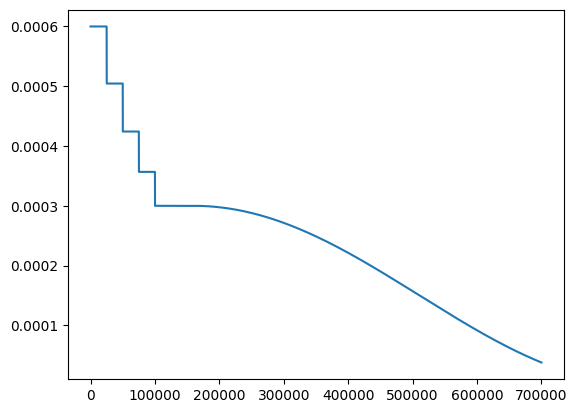

In [40]:
plt.plot(lr_list)

In [62]:
x = torch.ones(size=(4, 16, 4, 4))
m = nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2, padding=0, output_padding=(0, 0), groups=1, bias=False)
m(x).shape


torch.Size([4, 8, 8, 8])

# 01


In [1]:
import os, sys 
import itertools
import collections
import random
import time 
import logging

from PIL import Image
from skimage import img_as_ubyte
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pyplot import imread

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import MultiStepLR, CosineAnnealingLR, SequentialLR

#########################################################################################################
torch.set_float32_matmul_precision('high')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ROOT_PROJECT = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/ImageRestoration-Development-Unrolling/"
ROOT_DATASET = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/"
torch.set_default_device(DEVICE)

#########################################################################################################

sys.path.append(os.path.join(ROOT_PROJECT, 'exploration/model_multiscale_mixture_GLR/lib'))
from dataloader_v2 import ImageSuperResolution
import model_GLR_GTV_deep_v13 as model_structure
pd.set_option('display.max_colwidth', None)


In [10]:
CHECKPOINT_DIR = os.path.join(ROOT_PROJECT, "exploration/model_multiscale_mixture_GLR/result/model_test31_v13/checkpoints/")
training_state_path = os.path.join(CHECKPOINT_DIR, 'checkpoints_epoch00_iter0300k.pt')
training_state = torch.load(training_state_path, weights_only=False)

model =  model_structure.AbtractMultiScaleGraphFilter(
    n_channels_in=3, 
    n_channels_out=3, 
    dims=[48, 96, 192, 384],
    hidden_dims=[96, 192, 384, 768],
    nsubnets=[1, 1, 1, 1],
    ngraphs=[8, 16, 16, 32], #[1, 2, 4, 8], 
    num_blocks=[4, 6, 6, 8], 
    num_blocks_out=4
).to(DEVICE)
model.load_state_dict(training_state["model"])
# model.compile()

<All keys matched successfully>

In [8]:

model.eval()
csv_path = os.path.join(ROOT_DATASET, "dataset/McMaster_testing_data_info.csv")
img_infos = pd.read_csv(csv_path, index_col='index')

paths = img_infos["path"].tolist()
paths = [
    os.path.join(ROOT_DATASET,path)
    for path in paths
]

sigma_test = 25.0
factor = 16
list_test_mse = []
random_state = np.random.RandomState(seed=2204)
test_i = 0
s = time.time()
for file_ in paths:
    torch.cuda.ipc_collect()
    torch.cuda.empty_cache()

    img = Image.open(file_)
    img_true_255 = np.array(img).astype(np.float32)
    img_true = img_true_255 / 255.0

    noisy_img_raw = img_true.copy()
    noisy_img_raw += random_state.normal(0, sigma_test/255., img_true.shape)

    noisy_img = torch.from_numpy(noisy_img_raw).permute(2,0,1)
    noisy_img = noisy_img.unsqueeze(0)

    h,w = noisy_img.shape[2], noisy_img.shape[3]
    H,W = ((h+factor)//factor)*factor, ((w+factor)//factor)*factor
    padh = H-h if h%factor!=0 else 0
    padw = W-w if w%factor!=0 else 0
    noisy_img = nn.functional.pad(noisy_img, (0,padw,0,padh), 'reflect')

    with torch.no_grad():
        restored = model(noisy_img.to(DEVICE))

    restored = restored[:,:,:h,:w]
    restored = torch.clamp(restored,0,1).cpu().detach().permute(0, 2, 3, 1).squeeze(0).numpy().copy()

    restored = img_as_ubyte(restored).astype(np.float32)
    test_mse_value = np.square(img_true_255- restored).mean()
    list_test_mse.append(test_mse_value)
    print(f"test_i={test_i} time={time.time()-s} test_i_psnr_value={20 * np.log10(255.0 / np.sqrt(test_mse_value))}")  
    test_i += 1
    s = time.time()

psnr_testing = 20 * np.log10(255.0 / np.sqrt(list_test_mse))
print(f"FINISH TESTING  -  psnr_testing={np.mean(psnr_testing)}")
model.train()



test_i=0 time=0.6890604496002197 test_i_psnr_value=29.24049186706543
test_i=1 time=0.7794215679168701 test_i_psnr_value=33.78015899658203
test_i=2 time=0.8811635971069336 test_i_psnr_value=33.9612922668457
test_i=3 time=0.8006758689880371 test_i_psnr_value=35.194183349609375
test_i=4 time=0.7746658325195312 test_i_psnr_value=37.8023681640625
test_i=5 time=0.7949795722961426 test_i_psnr_value=35.089908599853516
test_i=6 time=0.7424466609954834 test_i_psnr_value=34.82344436645508
test_i=7 time=0.8088281154632568 test_i_psnr_value=30.306798934936523
test_i=8 time=0.7753331661224365 test_i_psnr_value=30.580310821533203
test_i=9 time=0.7984919548034668 test_i_psnr_value=31.884693145751953
test_i=10 time=0.7922468185424805 test_i_psnr_value=31.932828903198242
test_i=11 time=0.792827844619751 test_i_psnr_value=30.69775390625
test_i=12 time=0.7955715656280518 test_i_psnr_value=33.99251937866211
test_i=13 time=0.7767887115478516 test_i_psnr_value=31.96942138671875
test_i=14 time=0.7694067955017

AbtractMultiScaleGraphFilter(
  (patch_3x3_embeding): ReginalPixelEmbeding(
    (channels_local_linear_op01): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=replicate)
  )
  (encoder_scale_00): Sequential(
    (0): LocalNonLinearBlock(
      (norm): CustomLayerNorm(
        (weighted_transform): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1), groups=48, bias=False)
      )
      (local_linear): LocalGatedLinearBlock(
        (channels_linear_op): Conv2d(48, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (channels_local_linear_op): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=192, bias=False, padding_mode=replicate)
        (project_out): Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
    )
    (1): LocalNonLinearBlock(
      (norm): CustomLayerNorm(
        (weighted_transform): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1), groups=48, bias=False)
      )
      (local_linea

In [3]:


LOG_DIR = os.path.join(ROOT_PROJECT, "exploration/model_multiscale_mixture_GLR/scripts/")
LOGGER = logging.getLogger("main")
logging.basicConfig(
    format='%(asctime)s: %(message)s', 
    datefmt='%m/%d/%Y %I:%M:%S %p',
    filename=os.path.join(LOG_DIR, 'non.log'), 
    level=logging.INFO
)

VERBOSE_RATE = 1000

(H_train01, W_train01) = (64, 64)
(H_train02, W_train02) = (128, 128)
(H_train03, W_train03) = (256, 256)
(H_train04, W_train04) = (512, 512)


train_dataset01 = ImageSuperResolution(
    csv_path=os.path.join(ROOT_DATASET, "dataset/DFWB_training_data_info.csv"),
    dist_mode="vary_addictive_noise",
    lambda_noise=[[1.0, 10.0, 15.0, 20.0, 25.0], [0.1, 0.1, 0.1, 0.1, 0.6]],
    use_data_aug=True,
    patch_size=(H_train02,W_train02),
    max_num_patchs=800000,
    root_folder=ROOT_DATASET,
    logger=LOGGER,
    device=torch.device("cpu"),
)
data_train_batched01 = torch.utils.data.DataLoader(
    train_dataset01, batch_size=16, num_workers=4
)

# 01


In [34]:
import os, sys 
import itertools
import collections
import random
import time 
import logging

from PIL import Image
from skimage import img_as_ubyte
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pyplot import imread

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import MultiStepLR, CosineAnnealingLR, SequentialLR

#########################################################################################################
torch.set_float32_matmul_precision('high')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ROOT_PROJECT = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/ImageRestoration-Development-Unrolling/"
ROOT_DATASET = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/"

#########################################################################################################

sys.path.append(os.path.join(ROOT_PROJECT, 'exploration/model_multiscale_mixture_GLR/lib'))
from dataloader_v3 import ImageSuperResolution
import model_GLR_GTV_deep_v13 as model_structure
pd.set_option('display.max_colwidth', None)


In [10]:
model = model_structure.AbtractMultiScaleGraphFilter(
    n_channels_in=3, 
    n_channels_abtract=48, 
    n_channels_out=3, 
    dims=[48, 96, 192, 384],
    hidden_dims=[128, 256, 512, 1024],
    nsubnets=[1, 1, 1, 1],
    ngraphs=[8],
    num_blocks=[4, 4, 4, 4], 
    num_blocks_out=4
).to(DEVICE)


s = 0
for p in model.parameters():
    s += np.prod(np.array(p.shape))
    # print(p.dtype, np.array(p.shape), s)

print(f"Init model with total parameters: {s}")

Init model with total parameters: 9891168


In [35]:

LOG_DIR = os.path.join(ROOT_PROJECT, "exploration/model_multiscale_mixture_GLR/scripts/")
LOGGER = logging.getLogger("main")
logging.basicConfig(
    format='%(asctime)s: %(message)s', 
    datefmt='%m/%d/%Y %I:%M:%S %p',
    filename=os.path.join(LOG_DIR, 'non.log'), 
    level=logging.INFO
)

train_dataset = ImageSuperResolution(
    csv_path=os.path.join(ROOT_DATASET, "dataset/DFWB_training_data_info.csv"),
    dist_mode="addictive_noise",
    lambda_noise=25.0,
    use_data_aug=True,
    patch_size=(128,128),
    max_num_patchs=200000,
    root_folder=ROOT_DATASET,
    logger=LOGGER,
    device=torch.device("cpu"),
)


In [29]:
train_dataset.patchs_data.reset_index().query("resize==False")

,index,resize,height,width,nchannels,path,row,col,padding
6,170766,False,343,500,3,/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/WaterlooED/02204.bmp,0,0,True
11,142792,False,322,450,3,/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/WaterlooED/00284.bmp,0,0,True
14,8311,False,321,481,3,/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/BSD400/107072.jpg,0,0,True
21,64914,False,375,500,3,/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/WaterlooED/00571.bmp,0,0,True
22,103156,False,315,441,3,/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/WaterlooED/04080.bmp,0,0,True
...,...,...,...,...,...,...,...,...,...
199966,199289,False,305,460,3,/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/WaterlooED/04679.bmp,0,0,True
199969,57351,False,448,331,3,/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/WaterlooED/01693.bmp,0,0,True
199973,121116,False,306,460,3,/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/WaterlooED/04671.bmp,0,0,True
199985,14570,False,379,469,3,/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/WaterlooED/02338.bmp,0,0,True


In [36]:

data_train_batched01 = torch.utils.data.DataLoader(
    train_dataset, batch_size=16, num_workers=4
)
for patchs_noisy, patchs_true in data_train_batched01:

    img_true = patchs_true.detach().cpu().numpy()
    # img_true = np.clip(patchs_true.detach().cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
    img_noise = patchs_noisy.detach().cpu().numpy()
    # img_noise = np.clip(patchs_noisy.detach().cpu().numpy(), a_min=0.0, a_max=1.0).astype(np.float64)
    break

In [32]:
patchs_noisy, patchs_true = train_dataset[21]

img_true = patchs_true.detach().cpu().numpy()
img_noise = patchs_noisy.detach().cpu().numpy()

TypeError: Invalid shape (16, 128, 128, 3) for image data

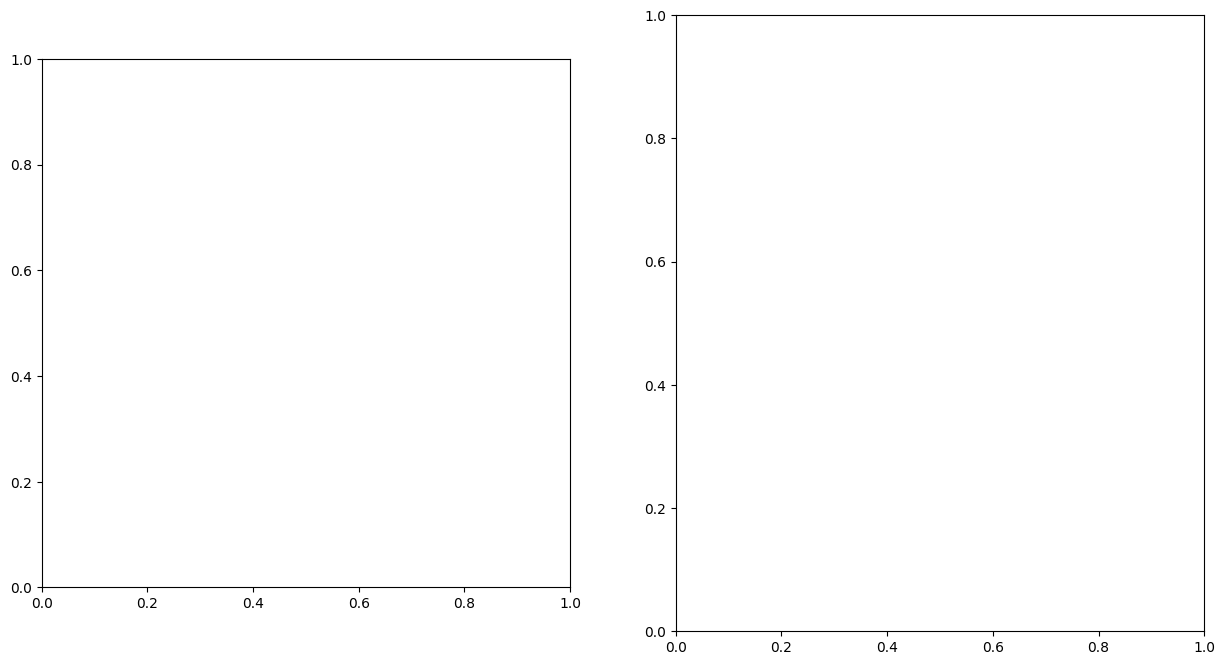

In [ ]:
for i in range(16):
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 8))
    ax[0].imshow((img_true[i]*255).astype(np.uint8))
    ax[0].set_title("True Image")
    ax[1].imshow((img_noise[i]*255).astype(np.uint8))
    ax[1].set_title("Noisy Image")
    plt.show()

# 01


In [1]:
import os, sys 
import itertools
import collections
import random
import time 
import logging

from PIL import Image
from skimage import img_as_ubyte
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pyplot import imread

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import MultiStepLR, CosineAnnealingLR, SequentialLR

#########################################################################################################
torch.set_float32_matmul_precision('high')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ROOT_PROJECT = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/ImageRestoration-Development-Unrolling/"
ROOT_DATASET = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/"

#########################################################################################################

sys.path.append(os.path.join(ROOT_PROJECT, 'exploration/model_multiscale_mixture_GLR/lib'))
from dataloader_v3 import ImageSuperResolution
import baselineSwinSR as model_structure
pd.set_option('display.max_colwidth', None)


/home/jovyan/shared/Thuc/hoodsgatedrive/envs/working2025_pytorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jovyan/shared/Thuc/hoodsgatedrive/envs/working2025_pytorch/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [4]:
opt = {
    "upscale": 1 ,
    "in_chans": 3 ,
    "img_size": 128 ,
    "window_size": 8  ,
    "img_range": 1.0 ,
    "depths": [6, 6, 6, 6, 6, 6] ,
    "embed_dim": 180 ,
    "num_heads": [6, 6, 6, 6, 6, 6],
    "mlp_ratio": 2 ,
    "upsampler": "",
    "resi_connection": "1conv",
    "init_type": "default"
  }

In [5]:
model = model_structure.SwinIR(**opt)

/home/jovyan/shared/Thuc/hoodsgatedrive/envs/working2025_pytorch/lib/python3.11/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
s = 0
for p in model.parameters():
    s += np.prod(np.array(p.shape))
    # print(p.dtype, np.array(p.shape), s)

print(f"Init model with total parameters: {s}")

Init model with total parameters: 11504163


# 01


In [2]:
import os, sys 
import itertools
import collections
import random
import time 
import logging

from PIL import Image
from skimage import img_as_ubyte
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pyplot import imread

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import MultiStepLR, CosineAnnealingLR, SequentialLR

#########################################################################################################
torch.set_float32_matmul_precision('high')
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
torch.set_default_device(DEVICE)
# torch.autograd.set_detect_anomaly(True)

ROOT_PROJECT = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/ImageRestoration-Development-Unrolling/"
ROOT_DATASET = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/"

#########################################################################################################

sys.path.append(os.path.join(ROOT_PROJECT, 'exploration/model_multiscale_mixture_GLR/lib'))
from dataloader_v2 import ImageSuperResolution
import model_GLR_GTV_deep_v13_no_orders_noGTV as model_structure

In [3]:

LOG_DIR = os.path.join(ROOT_PROJECT, "exploration/model_multiscale_mixture_GLR/scripts/")
LOGGER = logging.getLogger("main")
logging.basicConfig(
    format='%(asctime)s: %(message)s', 
    datefmt='%m/%d/%Y %I:%M:%S %p',
    filename=os.path.join(LOG_DIR, 'non.log'), 
    level=logging.INFO
)

train_dataset = ImageSuperResolution(
    csv_path=os.path.join(ROOT_DATASET, "dataset/DFWB_training_data_info.csv"),
    dist_mode="addictive_noise",
    lambda_noise=25.0,
    use_data_aug=True,
    patch_size=(128,128),
    max_num_patchs=200000,
    root_folder=ROOT_DATASET,
    logger=LOGGER,
    device=torch.device("cpu"),
)


In [4]:

data_train_batched01 = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, num_workers=4
)

In [7]:
model = model_structure.OneGraphFilter( 
    n_channels_in=3, 
    n_channels_hidden=96, 
    n_channels_out=3, 
)

In [8]:
for patchs_noisy, patchs_true in data_train_batched01:
    patchs_noisy = patchs_noisy.to(DEVICE)
    patchs_true = patchs_true.to(DEVICE) 
    reconstruct_patchs = model(patchs_noisy.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
    break

AttributeError: 'tuple' object has no attribute 'view'

In [ ]:
6291456 / 4 / 128 / 128

96.0

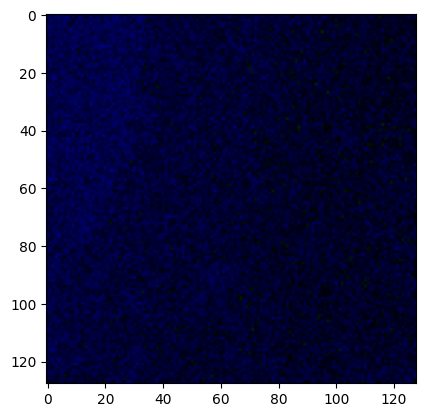

In [6]:
plt.imshow(reconstruct_patchs[0].cpu().detach().numpy())

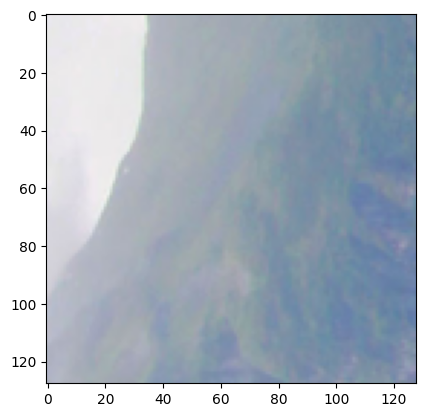

In [7]:
plt.imshow(patchs_true[0].cpu().numpy())